# The Global Greats: Nobel Laureates
## - By Sakshat Rao

### The Nobel Prize is an accomplishment that symbolizes utmost contribution towards the betterment of society. For several years, people have performed incredible work through scientific discoveries, brilliant literature and even inspiring peace-making. And the nobel prize is an award that represents the gratitude that the world has towards such individuals and organizations.

### For this notebook, I wanted to dive deeper into the people who have won Nobel Prizes, called Nobel Laureates. I wanted to explore interesting insights about such individuals and visualize them through beautiful graphs, plots and maps. So let's dive in!

In [1]:
install.packages('countrycode')

library(tidyverse)
library(ggplot2)
library(ggpubr)
library(dplyr)
library(countrycode)
library(rgdal)
library(broom)
library(repr)
library(reshape)
library(reshape2)
library(RColorBrewer)
library(zoo)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: magrittr


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: sp

rgdal: version: 1.4-8, (SVN revision 845)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.4.0, released 2018/12/14
 Path to GDAL shared files: /usr/share/gdal
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 5.2.0, September

In [2]:
raw_data <- read.csv('../input/nobel-prize-winner-1901-to-2020/nobel_prize_awarded_country_details_1901_2020_v3.csv', colClasses = c('character', 'integer', 'character', 'character', NA, NA, 'character', 'character'))

# Incorrect entry for Henry Kissinger
raw_data[raw_data$Name == 'Henry Kissinger', ]$Year <- 1973
raw_data[raw_data$Name == 'Henry Kissinger', ]$Countries <- 'United States, Germany'

# Filling a few entries' countries
raw_data[raw_data$Name == 'Tu Youyou', ]$Countries <- "China, People's Republic of"
raw_data[raw_data$Name == 'Andrea M. Ghez', ]$Countries <- "United States"
raw_data[raw_data$Name == 'Charles M. Rice', ]$Countries <- "United States"
raw_data[raw_data$Name == 'Emmanuelle Charpentier', ]$Countries <- "France"
raw_data[raw_data$Name == 'Harvey J. Alter', ]$Countries <- "United States"
raw_data[raw_data$Name == 'Jennifer Doudna', ]$Countries <- "United States"
raw_data[raw_data$Name == 'Louise Glück', ]$Countries <- "United States"
raw_data[raw_data$Name == 'Michael Houghton', ]$Countries <- "United Kingdom"
raw_data[raw_data$Name == 'Paul R. Milgrom', ]$Countries <- "United States"
raw_data[raw_data$Name == 'Reinhard Genzel', ]$Countries <- "Germany"
raw_data[raw_data$Name == 'Robert B. Wilson', ]$Countries <- "United States"
raw_data[raw_data$Name == 'Roger Penrose', ]$Countries <- "United Kingdom"

raw_data$Details <- NULL
raw_data$Description <- NULL

birth_dates <- read.csv('../input/nobel-laureates-birth-dates/nobel_birth_dates.csv', colClasses = c(NA, "Date"))
birth_years <- sapply(list(birth_dates[, 'DOB']), function(x) format(x, "%Y"))
birth_dates$BirthYr <- as.integer(birth_years)
birth_dates$DOB <- NULL

data <- merge(raw_data, birth_dates, by = 'Name', all.x = TRUE)

data <- data[order(nchar(as.character(data$Countries)), data$Countries, decreasing = TRUE), ]
data <- distinct(data, Name, Year, `.keep_all` = TRUE)
data$Country <- NULL

head(data)

Name              Year
1 Charles K. Kao    2009
2 Michael Levitt    2013
3 Leonid Hurwicz    2007
4 Vladimir Prelog   1975
5 Sydney Brenner    2002
6 Samuel C. C. Ting 1976
  Countries                                                   
1 China, Republic of, Hong Kong, United Kingdom, United States
2 Israel, South Africa, United Kingdom, United States         
3 Poland, Russia and Soviet Union, United States              
4 Bosnia and Herzegovina, Croatia, Switzerland                
5 South Africa, United Kingdom, United States                 
6 Taiwan (China, Republic of), United States                  
  Category               Gender BirthYr
1 Physics                Man    1933   
2 Chemistry              Man    1947   
3 Economics              Man    1917   
4 Chemistry              Man    1906   
5 Physiology or Medicine Man    1927   
6 Physics                Man    1936

### Over the course of my analysis, I wanted to answer these questions. For some of them, I had a basic intuition about what the answer would be, but I wanted to see it for myself through the data. And for some questions, I had no clue about what to expect!

#### [Global Distribution of Nobel Laureates](#1)
1. How are Nobel Laureates globally distributed?
2. Which continents boast more Nobel Laureates than others?
3. What is the value of the 'Nobel Laureate density' metric for different countries?
4. What is the global distribution of Nobel Laureates for different awards?

#### [Women Nobel Laureates](#2)
1. How represented are women among Nobel Laureates?
2. Are there certain awards which have significantly better representation of women than others?
3. Has the representation of women increased over time?

#### [Age of Nobel Laureates](#3)
1. What is the average age of Nobel Laureates when they receive their Nobel Prize?
2. What is the general trend of age of Nobel Laureates with time?
3. Are there awards/genders which boast significantly younger Nobel Laureates than others?

#### [Popularity of Nobel Laureates](#4)
1. Who are the most popular/celebrated/searched-for Nobel Laureates?
2. Do Nobel Laureates experience a significant boost in popularity during the time they are awarded the Nobel prize?

## Global Distribution <a id="1"></a>

### How are Nobel Laureates globally distributed?

This is a basic question I wanted to know about. How are Nobel Laureates distributed around the world? Is the distribution uniform among countries? Is there some kind of geographical biasness? Do developed countries dominate the scene? Let's find out.

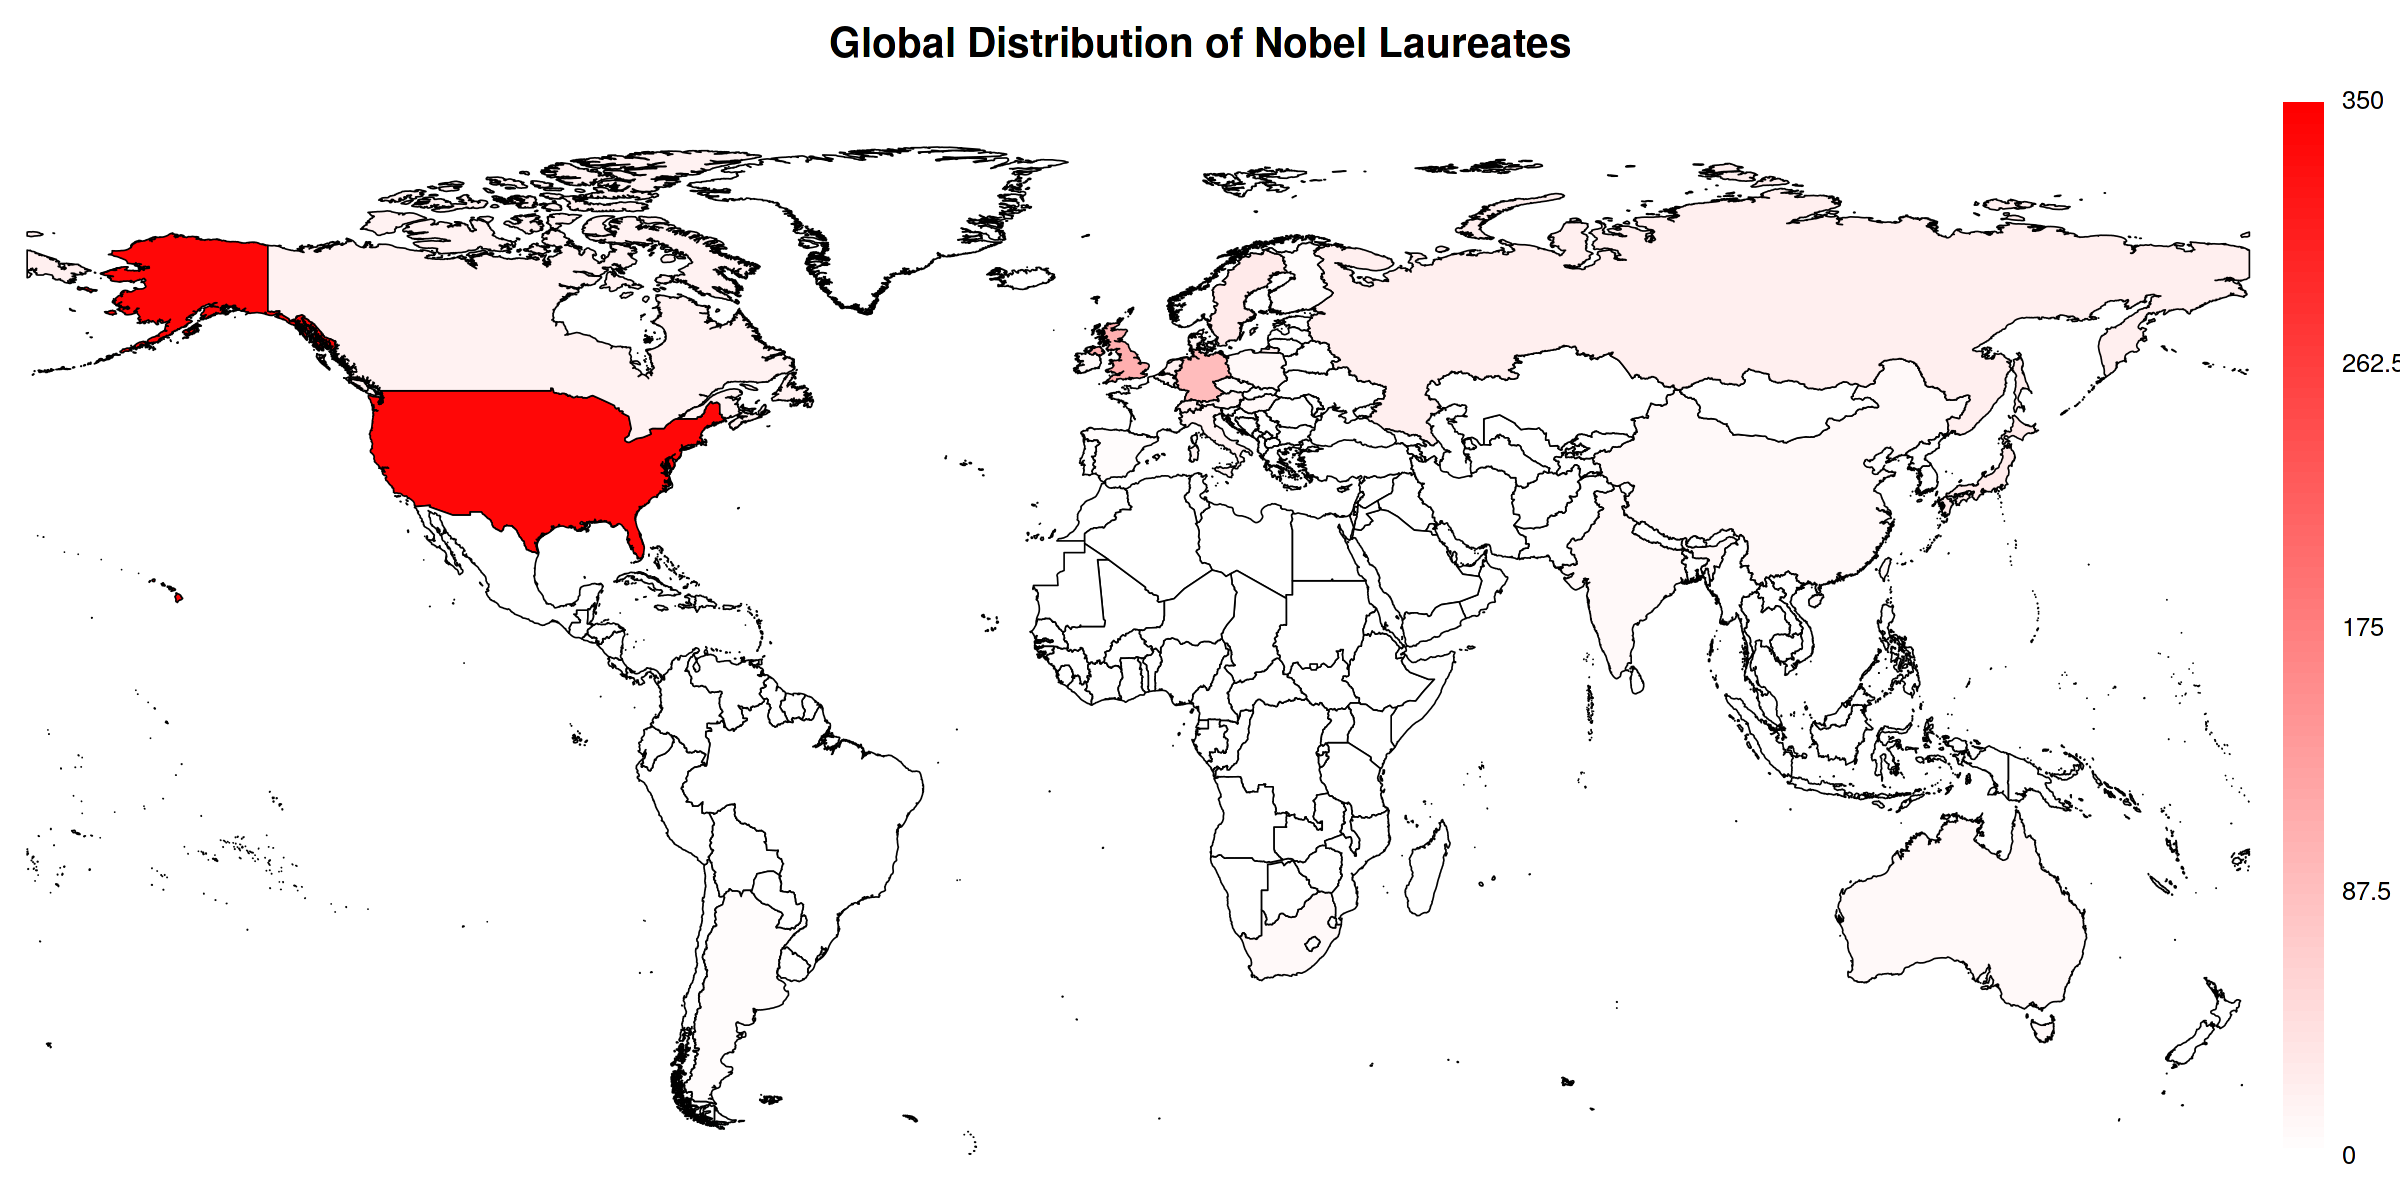

In [3]:
country_data <- raw_data[raw_data$Country != '-', ]

country_repl_map <- list(
    "China, People's Republic of" = 'China',
    'China, Republic of' = 'China',
    'Congo, Democratic Republic' = 'Congo, Democratic Republic of the',
    'Czech Republic' = 'Czechia',
    'Iran' = 'Iran (Islamic Republic of)',
    'Myanmar (Burma)' = 'Myanmar',
    'Palestine' = 'Palestine, State of',
    'Russia and Soviet Union' = 'Russian Federation',
    'South Korea' = 'Korea, Republic of',
    'Taiwan (China, Republic of)' = 'Taiwan, Province of China',
    'Tibet' = 'China',
    'United Kingdom' = 'United Kingdom of Great Britain and Northern Ireland',
    'United States' = 'United States of America',
    'Venezuela' = 'Venezuela (Bolivarian Republic of)',
    'Vietnam' = 'Viet Nam'
)

uniq_countries <- unique(country_data$Country)
for(idx in 1:length(uniq_countries))
{
    if(uniq_countries[idx] %in% names(country_repl_map))
        uniq_countries[idx] <- country_repl_map[[uniq_countries[[idx]]]]
}
uniq_countries <- unique(uniq_countries)
uniq_countries <- uniq_countries[order(uniq_countries)]
uniq_countries_code <- as.list(countrycode(unlist(uniq_countries), origin = 'country.name', destination = 'iso3c'))
names(uniq_countries_code) <- uniq_countries

plot_map <- function(data_vals, title, color1 = 'white', color2 = 'blue', color_default = 'white', min_val = 0, max_val = 1, width = 20, height = 10) {
    
    cntry_ogr <- readOGR(dsn= "../input/world-shapefiles/", layer="WB_countries_Admin0_10m", verbose=FALSE)
    cntry_data <- cntry_ogr@data
    cntry_polygons <- cntry_ogr@polygons

    colorbar <- function(cols, val_min = 0, val_max = 0, coords = c(-170, 190, -60, 90))
    {
        x_factor <- 1
        y_factor <- 1
        inc <- (coords[4] - coords[3]) / length(cols)
        for (col_ind in seq(cols))
            rect(coords[2] - 4.5 * x_factor, coords[3] + (col_ind - 1) * inc, coords[2] + 2 * x_factor, coords[3] + col_ind * inc, col = cols[col_ind], border = NA)
        text(coords[2] + 3 * y_factor, coords[3], paste(format(val_min, digits = 4)), pos = 4, cex = 1.25, col = 'black')
        text(coords[2] + 3 * y_factor, coords[4], paste(format(val_max, digits = 4)), pos = 4, cex = 1.25, col = 'black')
        text(coords[2] + 3 * y_factor, (coords[3] + coords[4])/2, paste(format((val_min + val_max) / 2, digits = 4)), pos = 4, cex = 1.25, col = 'black')
        text(coords[2] + 3 * y_factor, (3*coords[3] + coords[4])/4, paste(format((3 * val_min + val_max) / 4, digits = 4)), pos = 4, cex = 1.25, col = 'black')
        text(coords[2] + 3 * y_factor, (coords[3] + 3*coords[4])/4, paste(format((val_min + 3 * val_max) / 4, digits = 4)), pos = 4, cex = 1.25, col = 'black')
    }

    scaled_vals <- c(min_val, max_val, data_vals)
    binned_vals <- as.numeric(cut(scaled_vals, breaks = 100, labels = seq(100)))[3:length(scaled_vals)]
    cols = colorRampPalette(c(color1, color2))(100)

    options(repr.plot.width = width, repr.plot.height = height)
    par(mfrow = c(1, 1), mar = c(0, 0, 1.5, 0), xaxt = 'n', yaxt = 'n', fg = 'white', bg = 'white', cex.main = 2, oma = c(0, 0, 1, 0))
    plot(0, xlab = "", ylab = "", xlim = c(-170, 190), ylim = c(-60, 90), main = title)

    for (i in seq(length(cntry_polygons)))
    {
        polygons <- cntry_polygons[[i]]@Polygons
        cntry <- as.character(cntry_data[as.character(cntry_polygons[[i]]@ID), 'ISO_A3'])
        cntry_col <- cols[binned_vals[match(cntry, names(data_vals))]]
        if(is.na(cntry_col))
            cntry_col <- color_default
        for (j in seq(length(polygons)))
            polygon(attributes(cntry_ogr@polygons[[i]]@Polygons[[j]])$coords, col = cntry_col, border = 'black')
    }
    colorbar(cols, min_val, max_val)
}

all_countries <- unique(country_data$Country)
nobel_countries <- matrix(0, nrow = dim(data)[1], ncol = length(all_countries))
for (idx1 in seq(dim(data)[1]))
    for (idx2 in seq(length(all_countries)))
        if (grepl(all_countries[idx2], data[idx1, 'Countries'], fixed = TRUE))
            nobel_countries[idx1, idx2] <- 1

rowSum_nobel_countries <- rowSums(nobel_countries)
rowSum_nobel_countries <- matrix(rowSum_nobel_countries, nrow = length(rowSum_nobel_countries), ncol = length(all_countries))
country_contr <- nobel_countries / rowSum_nobel_countries
country_contr <- na.omit(country_contr)

for(idx in 1:length(all_countries))
    if(all_countries[idx] %in% names(country_repl_map))
        all_countries[idx] <- country_repl_map[[all_countries[[idx]]]]

total_country_contr <- as.data.frame(colSums(country_contr))
total_country_contr$Country <- all_countries
colnames(total_country_contr) <- c('Contribution', 'Country')
total_country_contr <- aggregate(Contribution ~ Country, data = total_country_contr, sum)

countries <- total_country_contr$Country
total_country_contr <- total_country_contr$Contribution
names(total_country_contr) <- sapply(countries, function(x) uniq_countries_code[x])
                                     
plot_map(total_country_contr, "Global Distribution of Nobel Laureates", min_val = 0, max_val = 350, color2 = 'red')

Now, we cannot expect all Nobel Laureates to belong to a single country. Many laureates were immigrants while some have multiple citizenships. Thus, to ensure equality among countries, we assign contributions to them.

For example, if Nobel Laureate 'A' is from India, then India gets a contribution of 1. If another Nobel Laureate 'B' is associated with India, USA and Canada, then these three countries get a contribution of 0.33 each. Eventually, we sum up these different contributions for different countries and map it.

As shown, USA has incredible dominance when it comes to Nobel Laureate global distribution. No other country (apart from UK and Germany) really comes close to it. This is not only because of the incredible technology, development, education and state-of-living in the States, but also because of the so-called 'brain drain' where many families immigrated from different countries to the States and prospered there.

### Which continents boast more Nobel Laureates than others?

Now let's take the same concept and apply it to continents. Based on the previous graph, I expected North America to be dominant based on how dominant USA was at the country-level.

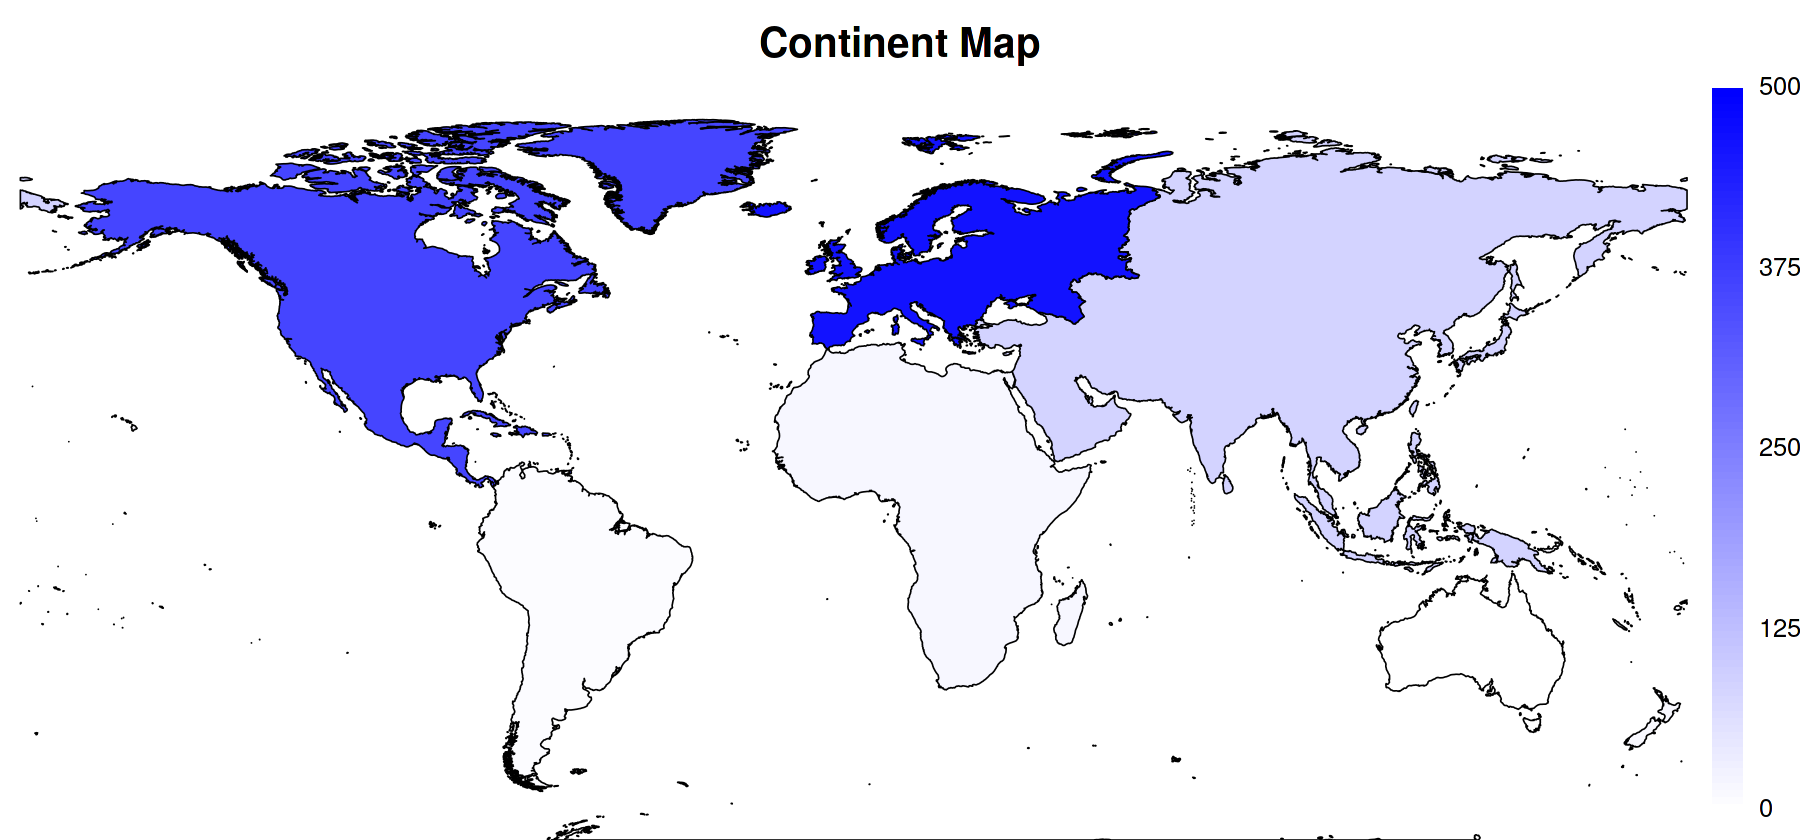

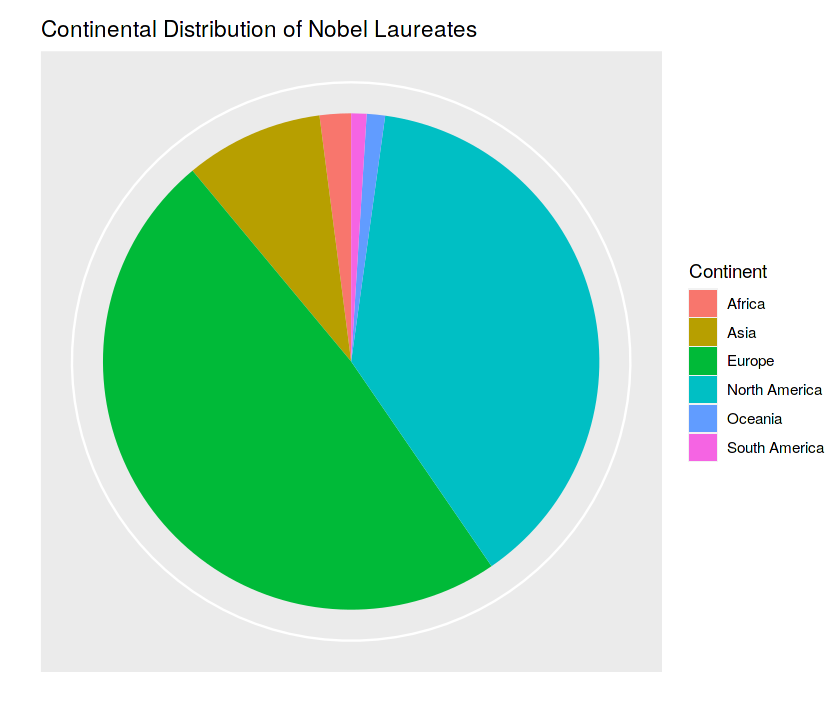

In [4]:
country_continent_map <- read.csv('../input/country-continent-map/country-and-continent-codes-list-csv_csv.csv')

country_continent_map <- country_continent_map[(country_continent_map$Three_Letter_Country_Code != ''), ]
country_continent_map <- country_continent_map[(country_continent_map$Three_Letter_Country_Code != 'ARM') | (country_continent_map$Continent_Code != 'AS'), ]
country_continent_map <- country_continent_map[(country_continent_map$Three_Letter_Country_Code != 'AZE') | (country_continent_map$Continent_Code != 'AS'), ]
country_continent_map <- country_continent_map[(country_continent_map$Three_Letter_Country_Code != 'CYP') | (country_continent_map$Continent_Code != 'AS'), ]
country_continent_map <- country_continent_map[(country_continent_map$Three_Letter_Country_Code != 'GEO') | (country_continent_map$Continent_Code != 'AS'), ]
country_continent_map <- country_continent_map[(country_continent_map$Three_Letter_Country_Code != 'KAZ') | (country_continent_map$Continent_Code != 'EU'), ]
country_continent_map <- country_continent_map[(country_continent_map$Three_Letter_Country_Code != 'RUS') | (country_continent_map$Continent_Code != 'EU'), ]
country_continent_map <- country_continent_map[(country_continent_map$Three_Letter_Country_Code != 'TUR') | (country_continent_map$Continent_Code != 'EU'), ]
country_continent_map <- country_continent_map[(country_continent_map$Three_Letter_Country_Code != 'UMI'), ]

rownames(country_continent_map) <- country_continent_map$Three_Letter_Country_Code

all_continents <- sapply(names(total_country_contr), function(x) country_continent_map[x, 'Continent_Name'])
total_continent_contr <- as.data.frame(total_country_contr)
total_continent_contr$Continent <- all_continents
colnames(total_continent_contr) <- c('Contribution', 'Continent')
rownames(total_continent_contr) <- NULL
total_continent_contr <- aggregate(Contribution ~ Continent, data = total_continent_contr, sum)
                         
data_vals <- total_continent_contr$Contribution
names(data_vals) <- total_continent_contr$Continent
min_val <- 0
max_val <- 500
title <- "Continent Map"
color1 <- 'white'
color2 <- 'blue'
color_default <- 'white'

cntry_ogr <- readOGR(dsn= "../input/continent-shapefiles/", layer="4a7d27e1-84a3-4d6a-b4c2-6b6919f3cf4b202034-1-2zg7ul.ht5ut", verbose=FALSE)
cntry_data <- cntry_ogr@data
cntry_polygons <- cntry_ogr@polygons

colorbar <- function(cols, val_min = 0, val_max = 0, coords = c(-170, 190, -60, 90))
{
    x_factor <- 1
    y_factor <- 1
    inc <- (coords[4] - coords[3]) / length(cols)
    for (col_ind in seq(cols))
        rect(coords[2] - 4.5 * x_factor, coords[3] + (col_ind - 1) * inc, coords[2] + 2 * x_factor, coords[3] + col_ind * inc, col = cols[col_ind], border = NA)
    text(coords[2] + 3 * y_factor, coords[3], paste(format(val_min, digits = 4)), pos = 4, cex = 1.25, col = 'black')
    text(coords[2] + 3 * y_factor, coords[4], paste(format(val_max, digits = 4)), pos = 4, cex = 1.25, col = 'black')
    text(coords[2] + 3 * y_factor, (coords[3] + coords[4])/2, paste(format((val_min + val_max) / 2, digits = 4)), pos = 4, cex = 1.25, col = 'black')
    text(coords[2] + 3 * y_factor, (3*coords[3] + coords[4])/4, paste(format((3 * val_min + val_max) / 4, digits = 4)), pos = 4, cex = 1.25, col = 'black')
    text(coords[2] + 3 * y_factor, (coords[3] + 3*coords[4])/4, paste(format((val_min + 3 * val_max) / 4, digits = 4)), pos = 4, cex = 1.25, col = 'black')
}

scaled_vals <- c(min_val, max_val, data_vals)
binned_vals <- as.numeric(cut(scaled_vals, breaks = 100, labels = seq(100)))[3:length(scaled_vals)]
cols = colorRampPalette(c(color1, color2))(100)

options(repr.plot.width = 15, repr.plot.height = 7)
par(mfrow = c(1, 1), mar = c(0, 0, 1.5, 0), xaxt = 'n', yaxt = 'n', fg = 'white', bg = 'white', cex.main = 2, oma = c(0, 0, 1, 0))
plot(0, xlab = "", ylab = "", xlim = c(-170, 190), ylim = c(-60, 90), main = title)
for (i in seq(length(cntry_polygons)))
{
    polygons <- cntry_polygons[[i]]@Polygons
    cntry <- as.character(cntry_data[as.character(cntry_polygons[[i]]@ID), 'CONTINENT'])
    cntry_col <- cols[binned_vals[match(cntry, names(data_vals))]]
    if(is.na(cntry_col))
        cntry_col <- color_default
    for (j in seq(length(polygons)))
        polygon(attributes(cntry_ogr@polygons[[i]]@Polygons[[j]])$coords, col = cntry_col, border = 'black')
}
colorbar(cols, min_val, max_val)

options(repr.plot.width = 7, repr.plot.height = 6)
pie_plot <- ggplot(total_continent_contr, aes(x = '', y = Contribution, fill = Continent)) + geom_bar(width = 1, stat = 'identity') + coord_polar("y", start = 0) + theme(axis.text.x = element_blank(), axis.ticks = element_blank()) + labs(title = "Continental Distribution of Nobel Laureates", x = '', y = '') + scale_y_continuous(breaks = c())
pie_plot

Rather surprisingly, North America & Europe have comparable contributions (in fact, Europe just pips North America!). It is surprising because it seems that the small contributions from the several European countries add up to pip the extremely large single contribution of the USA.

### What is the value of the decade-wise 'Nobel Laureate density' metric for different countries?

After analyzing the contributions of these countries, one of my doubts was "If a country has a larger population, wouldn't there be a statistically higher chance of having more Nobel Laureates?". For example, Greece has a smaller population than USA and maybe because of that, it is not able to have as many Nobel Laureates. Seems like a silly excuse, but I wanted to see how efficient countries were at producing Nobel Laureates from its population.

For this task, I define a simple metric called **Nobel Laureate density** which is defined as the number of Nobel Laureates per million citizens. But since the population of a country is dynamic and ever-changing, I define it for a given period of time, which in my case is 20 years.

For example, if India had 3 Nobel Laureates in the twenty years between 1990-2010 with an everage population of 50,000,000 in that period, then I define Nobel Laureate density between 1990-2010 as (3/50) = 0.06.

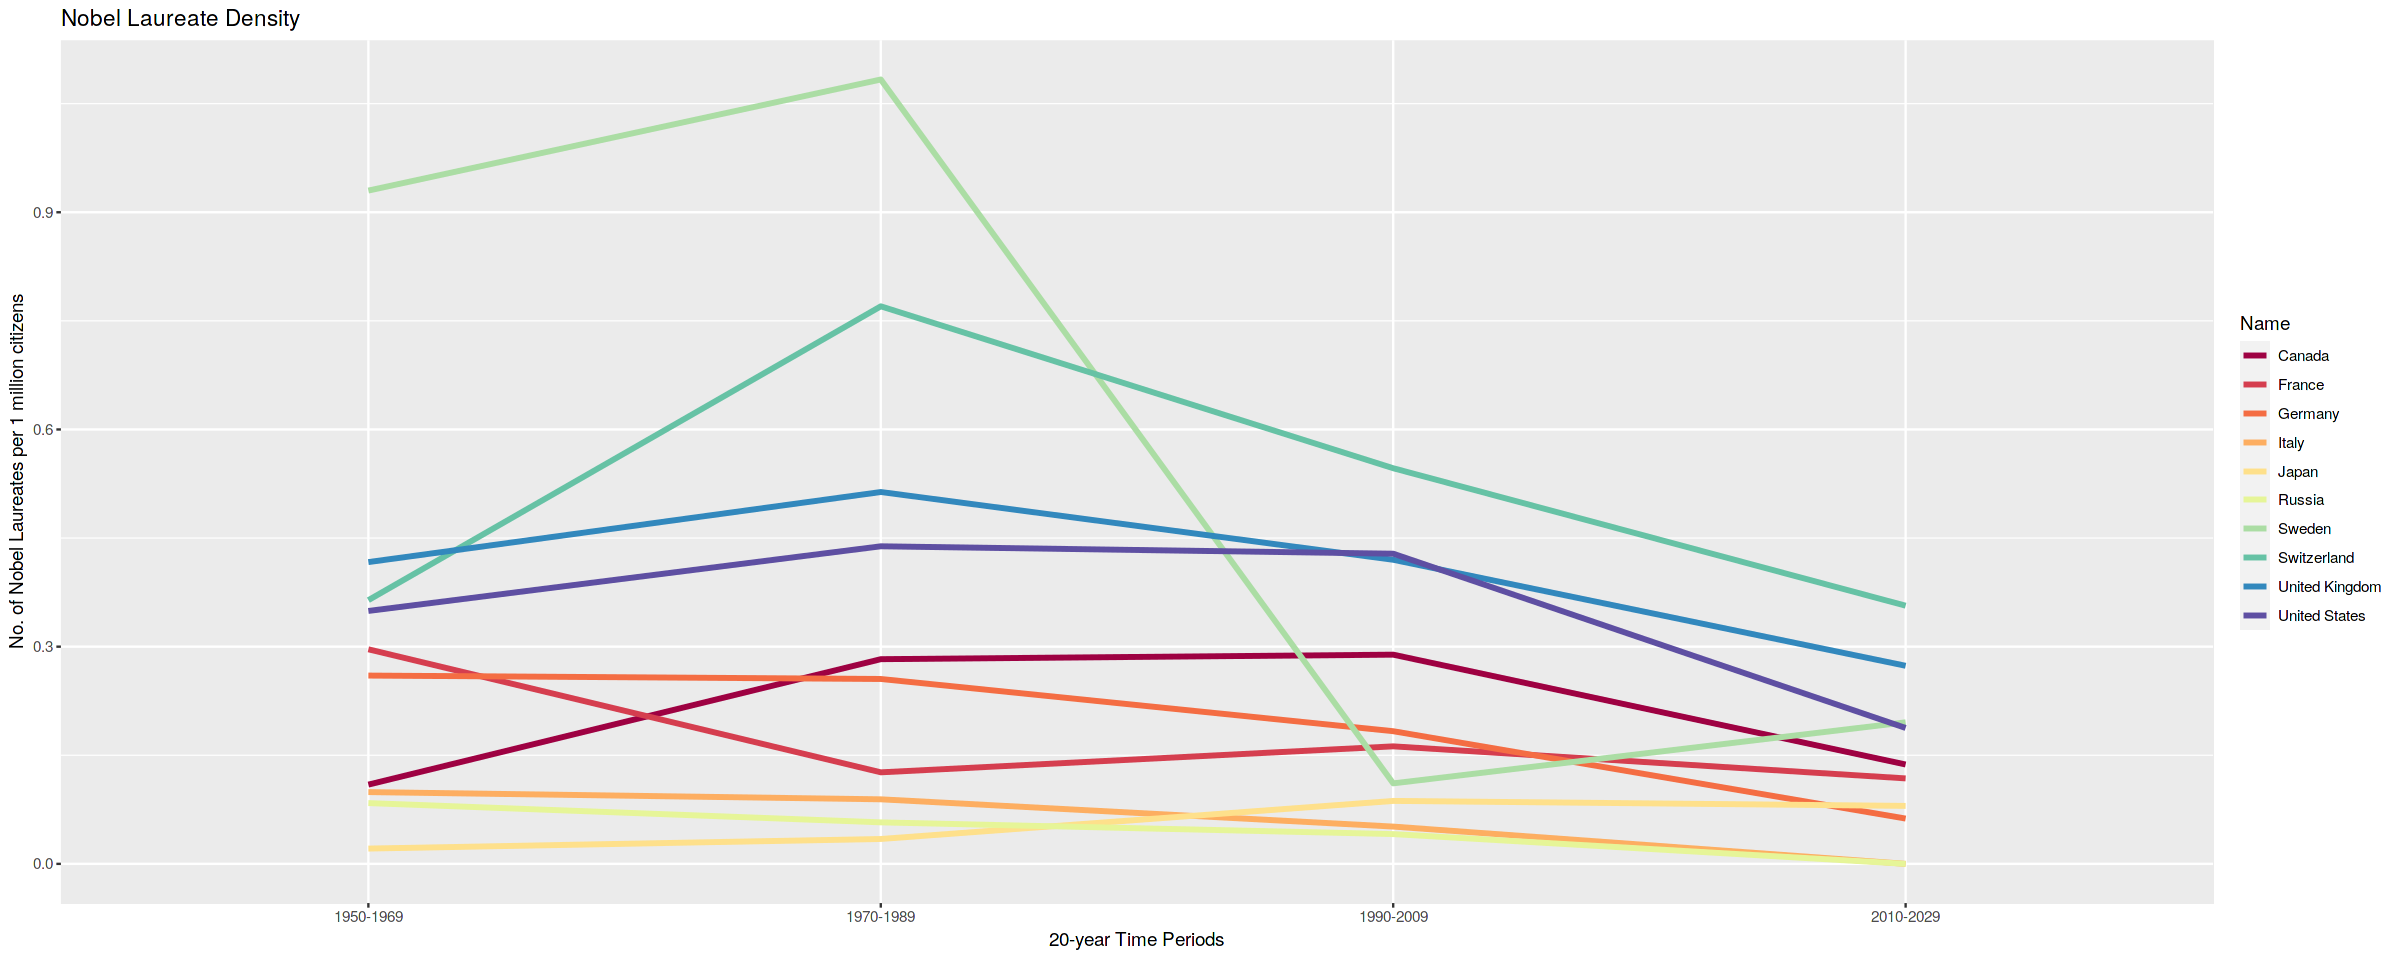

In [5]:
pop_data <- read.csv('../input/worldpopulation/midyear_population.csv')

pop_country_name_map <- list(
    'Russia and Soviet Union' = 'Russia',
    'Myanmar (Burma)' = 'Burma',
    'Czech Republic' = 'Czechia',
    'East Timor' = 'Timor-Leste',
    "China, Republic of" = 'China',
    "China, People's Republic of" = "China",
    'Congo, Democratic Republic' = 'Congo (Kinshasa)',
    'South Korea' = 'Korea South',
    'North Macedonia' = 'Macedonia',
    'Taiwan (China, Republic of)' = 'Taiwan'
)

pop_all_countries <- list()
for (country in unique(raw_data$Country))
{
    if(country %in% unique(pop_data$country_name))
        pop_all_countries[country] <- country
    else
        if(country %in% names(pop_country_name_map))
            pop_all_countries[country] <- pop_country_name_map[country]
}

decade_breaks <- c(1950, 1970, 1990, 2010)
decade_gap <- 20

all_country_decade_pop_data <- matrix(0, nrow = length(unique(pop_data$country_name)), ncol = length(decade_breaks))
pop_uniq_countries <- unique(pop_data$country_name)

for (country_idx in seq(1, length(pop_uniq_countries)))
{
    country_pop_data <- pop_data[pop_data$country_name == pop_uniq_countries[country_idx], ]
    country_pop_data <- country_pop_data[order(country_pop_data$year), ]

    for (decade_idx in seq(1, length(decade_breaks)))
    {
        all_decade_country_pop_data <- country_pop_data[(country_pop_data$year > decade_breaks[decade_idx]) & (country_pop_data$year <= decade_breaks[decade_idx] + decade_gap), ]
        if(dim(all_decade_country_pop_data)[1] == 0)
            print(c("Not found for ", country_name, " in ", decade_breaks[decade_idx]))
        all_country_decade_pop_data[country_idx, decade_idx] <- mean(all_decade_country_pop_data$midyear_population)
    }
}

all_country_decade_pop_data <- as.data.frame(all_country_decade_pop_data)
colnames(all_country_decade_pop_data) <- decade_breaks
rownames(all_country_decade_pop_data) <- pop_uniq_countries

find_decade <- function(x) {
    decade_range <- 0
    for (decade_break in decade_breaks)
    {
        if((x > decade_break) & (x <= decade_break + decade_gap))
            decade_range <- decade_break
    }
    decade_range
}
data$Decade <- sapply(data$Year, find_decade)

country_decade_count <- as.data.frame(matrix(0, ncol = length(decade_breaks)))
colnames(country_decade_count) <- decade_breaks

sample_country_data <- as.data.frame(matrix(0, ncol = length(decade_breaks)))
colnames(sample_country_data) <- decade_breaks

for (country in names(pop_all_countries))
{
    country_data <- data[sapply(data$Countries, function(x) grepl(country, x, fixed = TRUE)), ]
    country_data <- country_data[country_data$Decade > 0, ]
    if(dim(country_data)[1] > 0)
    {
        country_data <- aggregate(Name ~ Decade, data = country_data, FUN = length)
        decades <- country_data$Decade
        country_data$Decade <- NULL
        country_data <- as.data.frame(transpose(country_data))
        colnames(country_data) <- decades
        country_data <- merge(sample_country_data, country_data, all = TRUE)[2, ]
        country_data[is.na(country_data)] <- 0
        country_data <- country_data[, order(names(country_data))]
        country_decade_count[country, ] <- country_data
    }
}
                                
country_decade_count <- country_decade_count[2:dim(country_decade_count)[1], ]
country_decade_count <- country_decade_count[order(rowSums(country_decade_count), decreasing = TRUE)[1:10], ]
country_decade_count$Name <- as.factor(unlist(sapply(rownames(country_decade_count), function(x) pop_all_countries[x])))
                                                     
country_nobel_density <- merge(country_decade_count, all_country_decade_pop_data, by.x = 'Name', by.y = 0)
country_nobel_density <- aggregate(. ~ Name, data = country_nobel_density, sum)
for (decade_break in decade_breaks)
    country_nobel_density[, format(decade_break)] <- country_nobel_density[, paste(decade_break, '.x', sep = '')] * 1000000.0 / country_nobel_density[, paste(decade_break, '.y', sep = '')]
country_nobel_density <- country_nobel_density[, c(sapply(decade_breaks, function(x) format(x)), 'Name')]
country_nobel_density <- melt(country_nobel_density, id = 'Name')
country_nobel_density$variable <- as.factor(as.numeric(as.character(country_nobel_density$variable)))

options(repr.plot.width = 20, repr.plot.height = 8)
nobel_density_plot <- ggplot(data = country_nobel_density, aes(x = variable, y = value, colour = Name, group = Name)) + geom_line(size = 1.25) + scale_colour_brewer(palette = 'Spectral') + labs(title = "Nobel Laureate Density", x = '20-year Time Periods', y = 'No. of Nobel Laureates per 1 million citizens') + scale_x_discrete(breaks = decade_breaks, labels = as.list(sapply(decade_breaks, function(x) paste(x, '-', x + 19, sep = ''))))
nobel_density_plot

Quite interesting results! Here I have plotted the Nobel Laureate density of the top 10 countries. As it turns out, Sweden and Switzerland seem to have incredibly high Nobel Laureate densities which means that these countries perform very well based on their small populations. They are followed by UK and USA which are more populous but also have more Nobel Laureates.

**Fun Fact**: Sweden between the 1970s and 1990s had 1 Nobel Laureate per million citizens on average - imagine if countries like India or China (with their population in billions) could achieve that kind of efficiency!

### What is the global distribution of Nobel Laureates for different awards?

We looked at how all Nobel Laureates were distributed globally, now let's take a look at how Nobel Laureates for different awards are distributed globally.

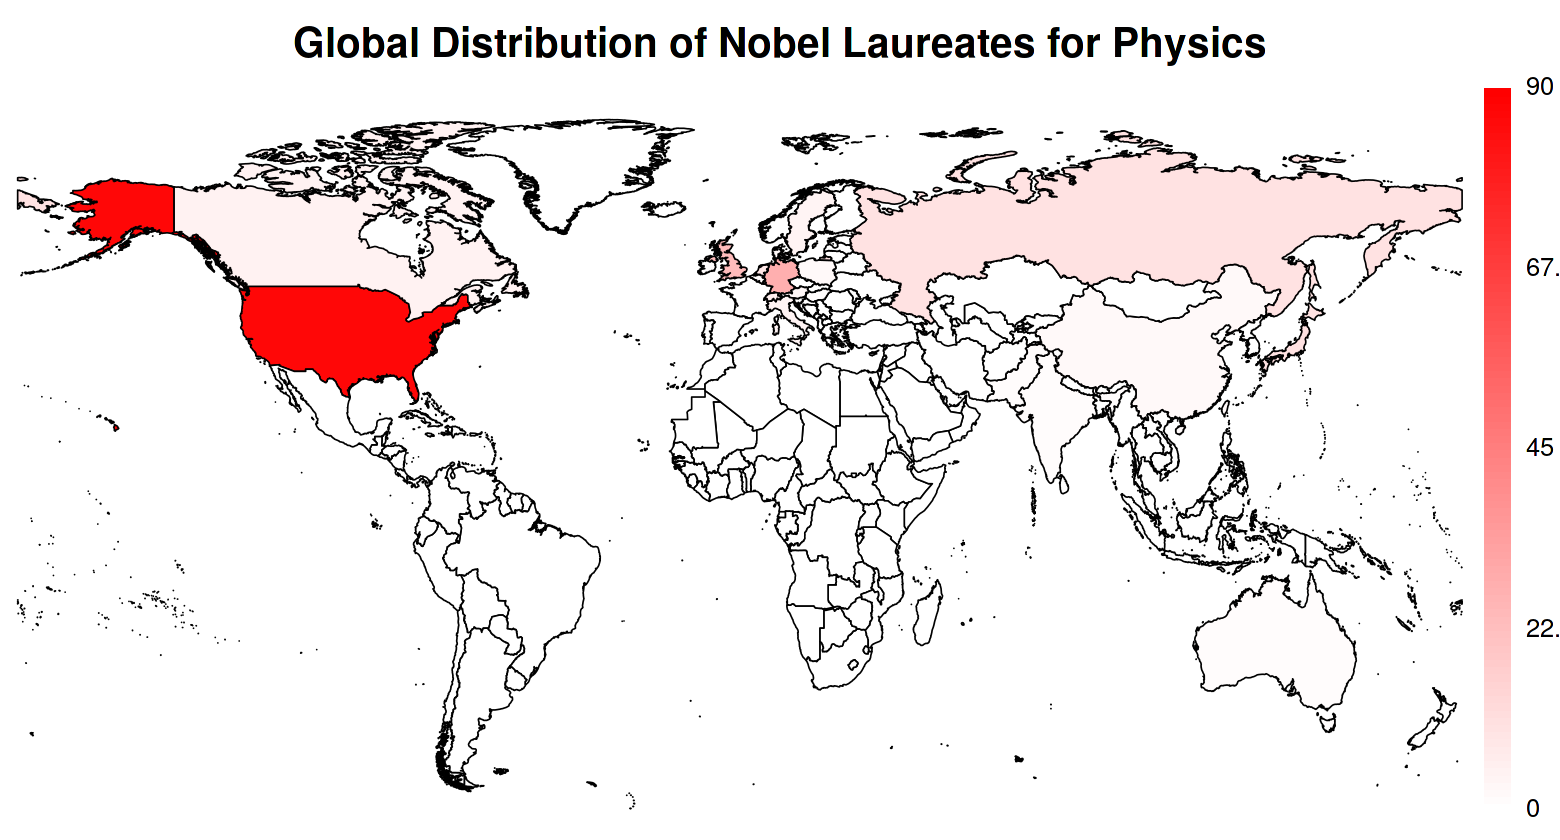

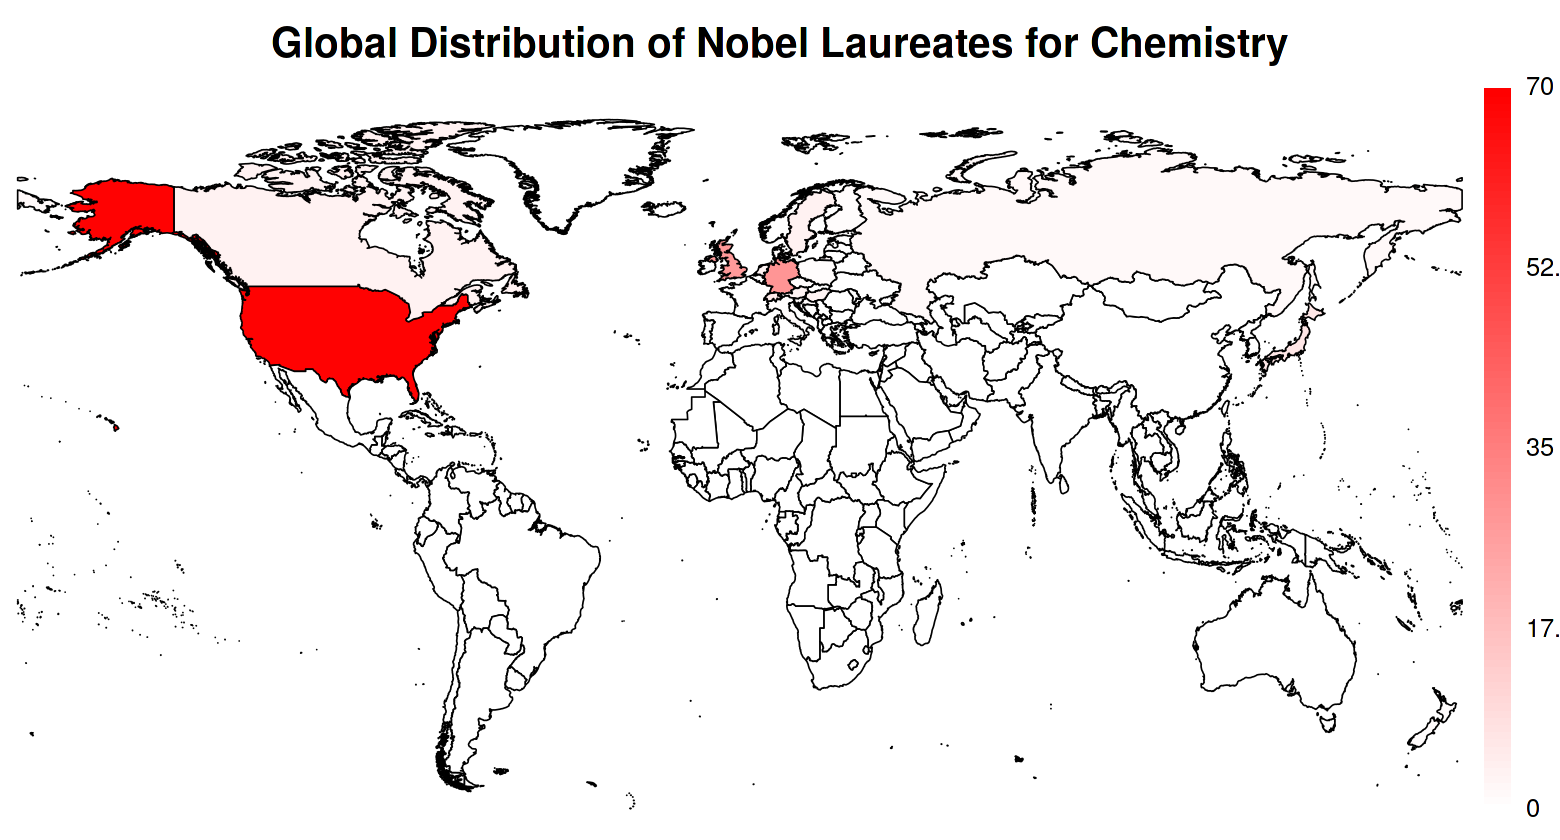

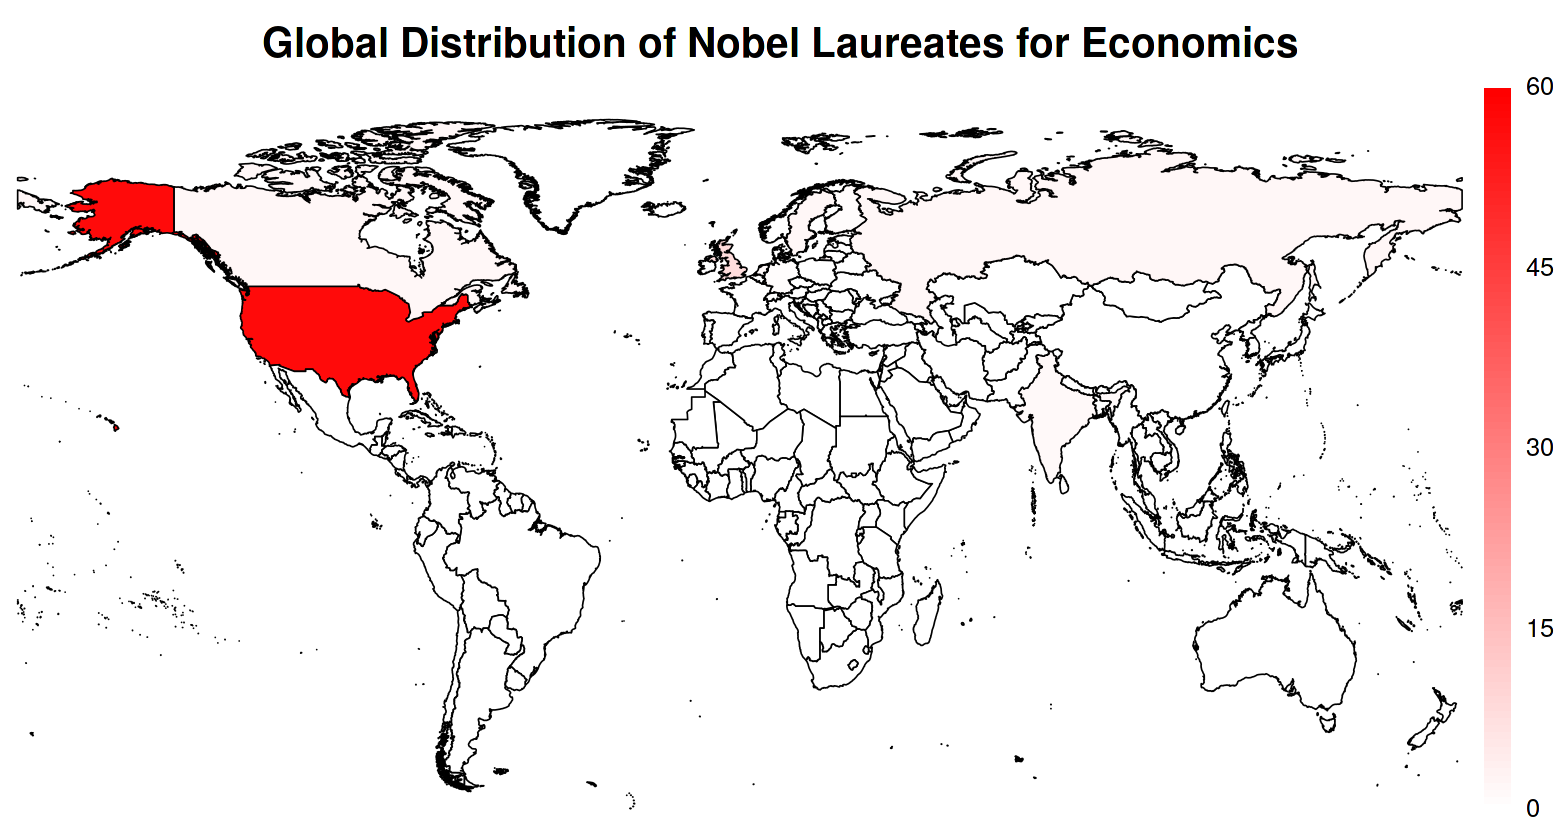

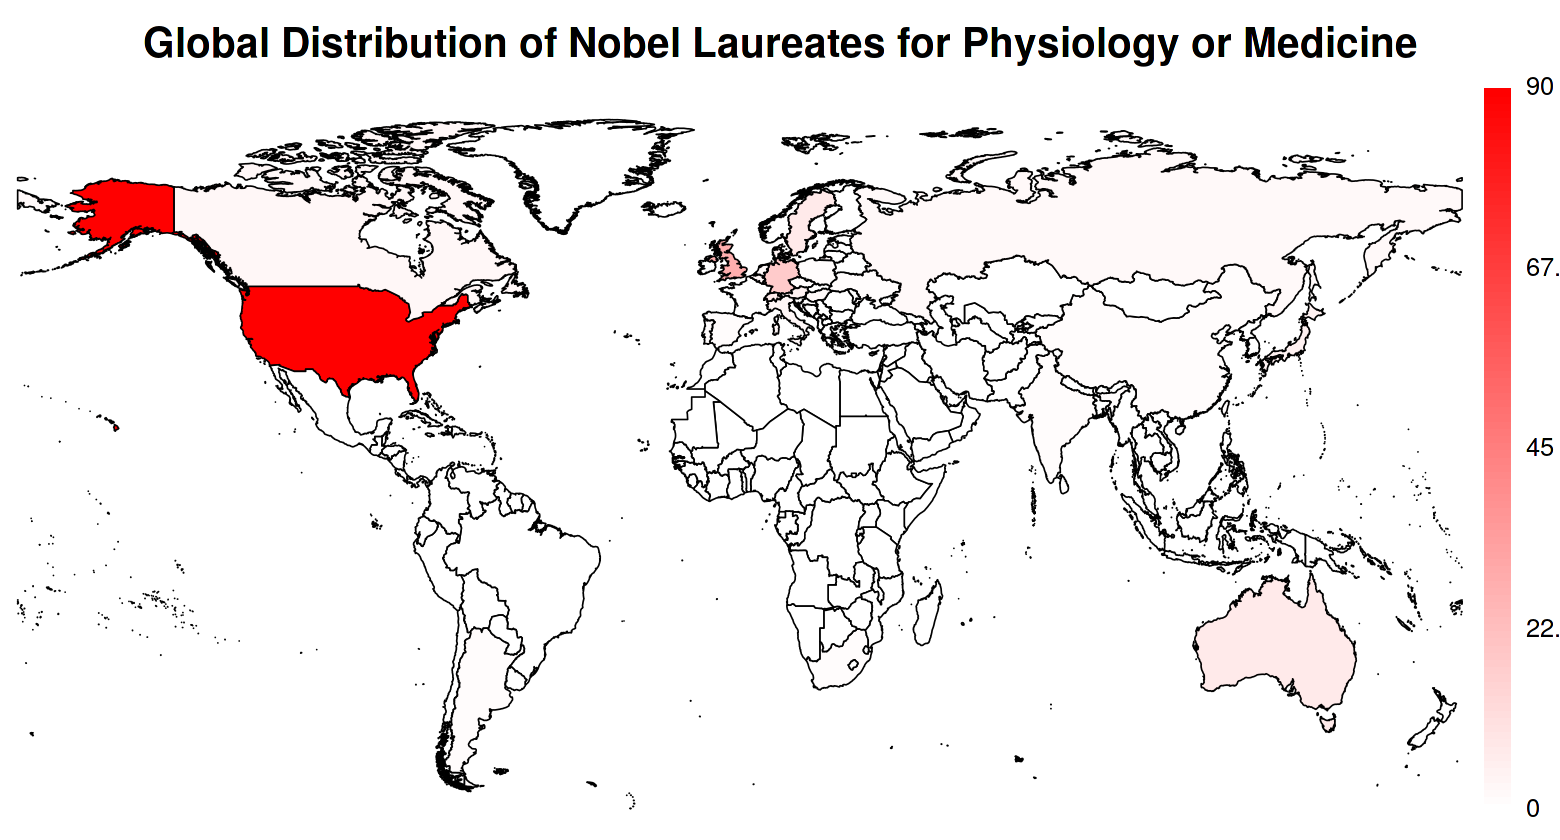

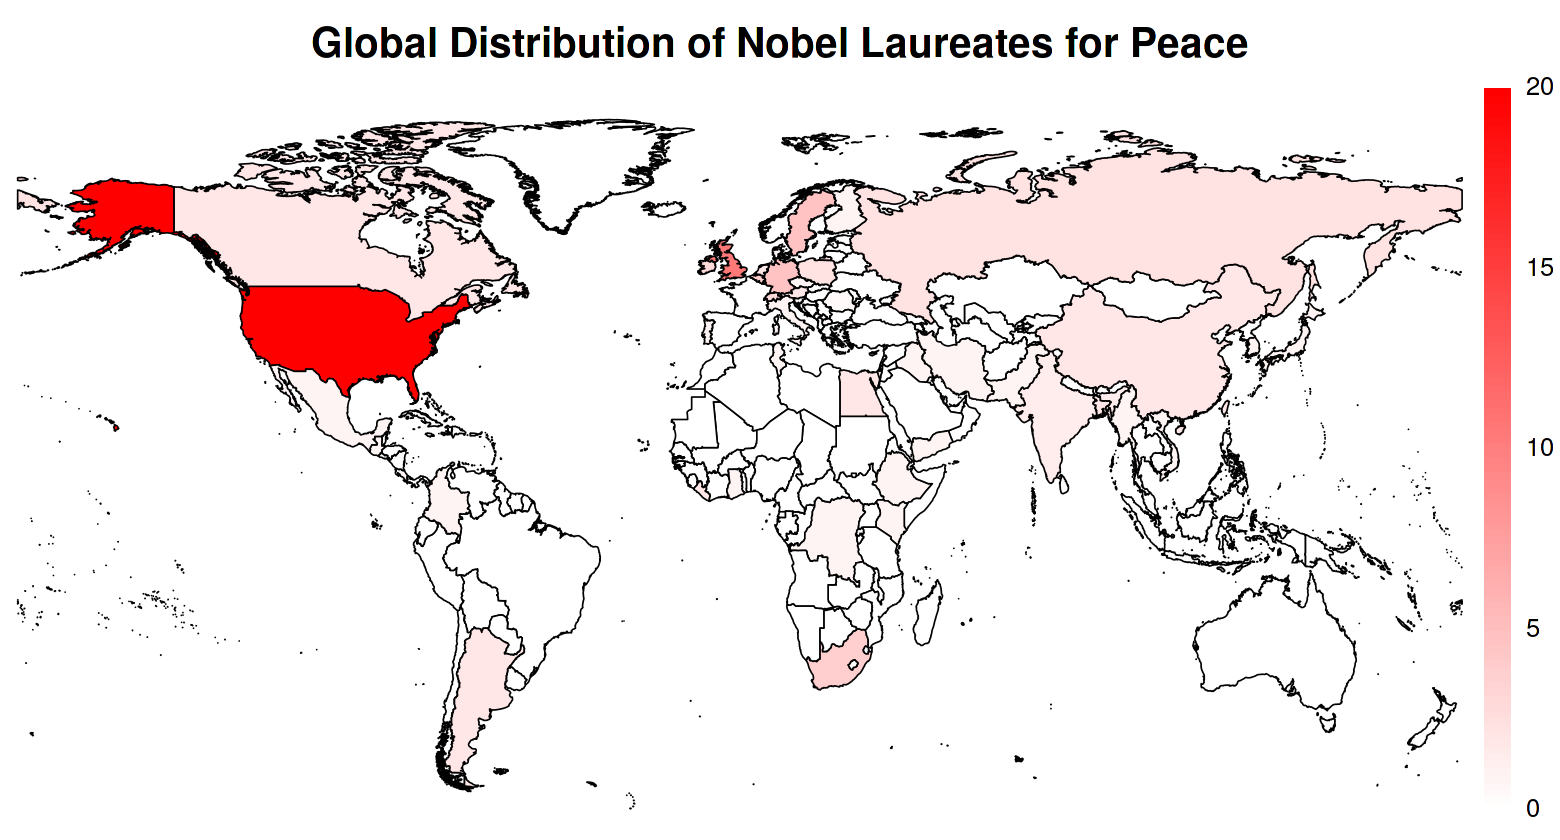

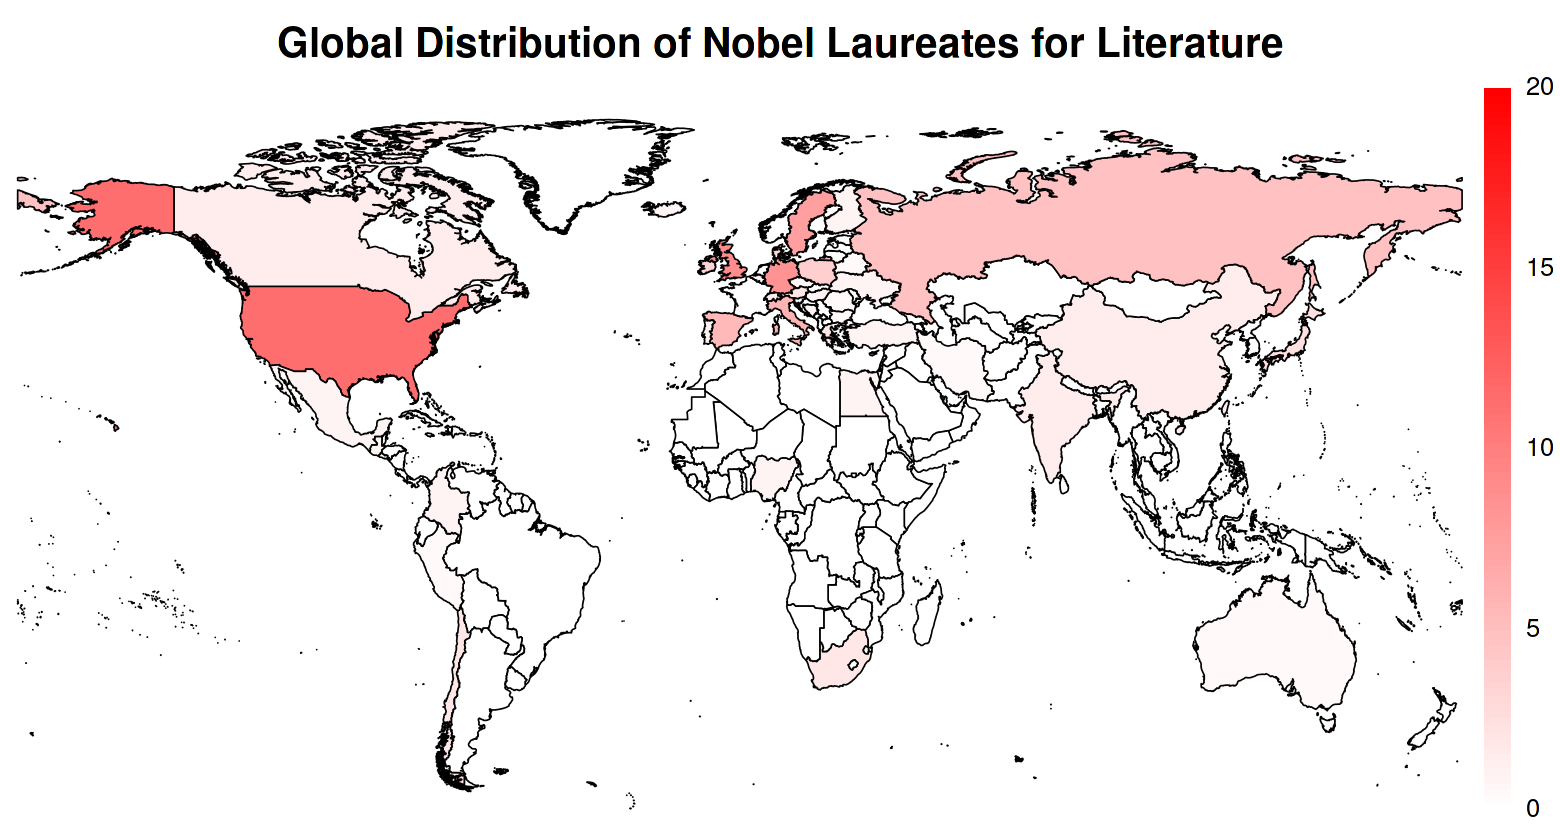

In [6]:
country_data <- raw_data[raw_data$Country != '-', ]

for (award_category in unique(data$Category))
{
    all_countries <- unique(country_data$Country)
    nobel_countries <- matrix(0, nrow = dim(data)[1], ncol = length(all_countries))
    for (idx1 in seq(dim(data)[1]))
    if(data[idx1, 'Category'] == award_category)
        for (idx2 in seq(length(all_countries)))
            if (grepl(all_countries[idx2], data[idx1, 'Countries'], fixed = TRUE))
                nobel_countries[idx1, idx2] <- 1

    rowSum_nobel_countries <- rowSums(nobel_countries)
    rowSum_nobel_countries <- matrix(rowSum_nobel_countries, nrow = length(rowSum_nobel_countries), ncol = length(all_countries))
    country_contr <- nobel_countries / rowSum_nobel_countries
    country_contr <- na.omit(country_contr)

    for(idx in 1:length(all_countries))
    if(all_countries[idx] %in% names(country_repl_map))
        all_countries[idx] <- country_repl_map[[all_countries[[idx]]]]

    total_country_contr <- as.data.frame(colSums(country_contr))
    total_country_contr$Country <- all_countries
    colnames(total_country_contr) <- c('Contribution', 'Country')
    total_country_contr <- aggregate(Contribution ~ Country, data = total_country_contr, sum)

    countries <- total_country_contr$Country
    total_country_contr <- total_country_contr$Contribution
    names(total_country_contr) <- sapply(countries, function(x) uniq_countries_code[x])

    plot_map(total_country_contr, paste("Global Distribution of Nobel Laureates for ", award_category, sep = ''), min_val = 0, max_val = as.integer(round(max(total_country_contr), -1)), color2 = 'red', width = 13, height = 7)
}

Global distribution for Nobel Laureates in Physics, Chemistry, Medicine and Economics are more-or-less similar to the overall global distribution. Where we find a change is for Peace and Literature. These two awards seem to have a very distributed representation around the world. Although USA still dominates these awards as well, but we can see contributions from many more Asian, African and South American countries.

One possible reason for this behaviour could be as follows - Physics, Chemistry, Medicine and Economics are probably more technical fields because of which developed countries like USA, UK and Germany dominate the scene. However, Literature and Peace are not restricted by how technologically advanced the country is, which is probably why we find more representation, sometimes even from countries with low development.

## Women Nobel Laureates <a id="2"></a>

### How represented are women among Nobel Laureates?

This is a question that is gaining more and more traction, especially today when people are starting to realize there needs to be equity for women in different fields. Let us see whether women are well represented among Nobel Laureates.

[1] "Average Women Percentage Representation: 6.16%"


Using Name as value column: use value.var to override.



[1] "Percentage of years when no woman was awarded the Nobel Prize: 65.8%"
[1] "Maximum Woman Representation attained was 38.5% in 2009"



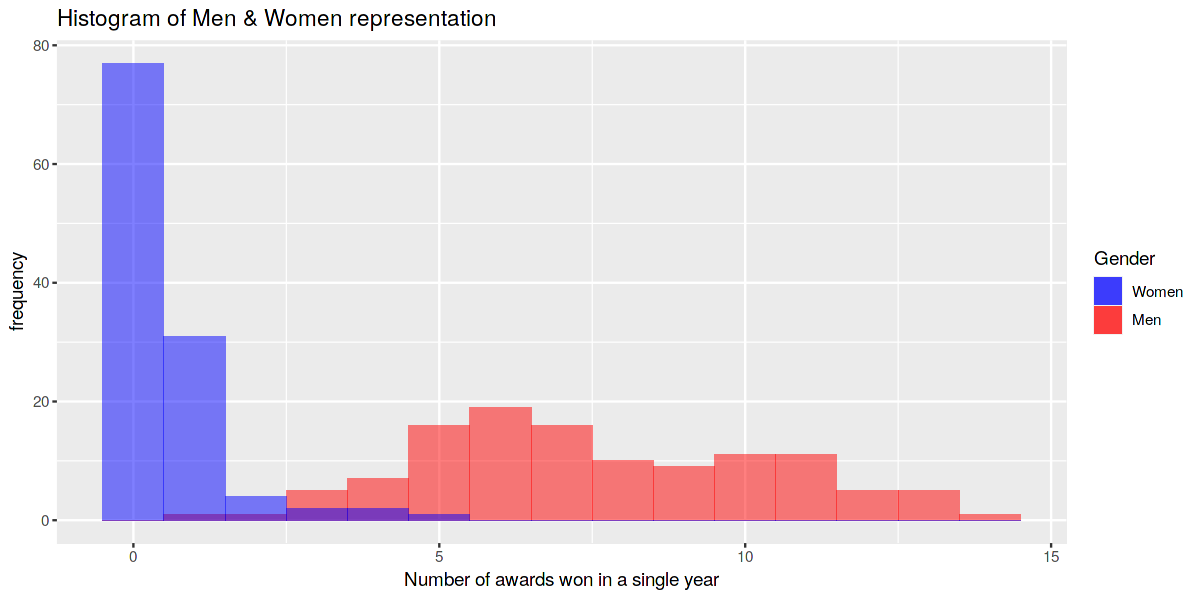

In [7]:
total_women <- dim(data[data$Gender == 'Woman', ])[1]
total_men <- dim(data[data$Gender == 'Man', ])[1]
total_orgs <- dim(data[data$Gender == 'Organization', ])[1]

women_perc <- total_women / (total_women + total_men) * 100
print(paste("Average Women Percentage Representation: ", format(women_perc, digits = 3), "%", sep = ''))

year_gender_data <- aggregate(Name ~ Year + Gender, data = data, length)
year_gender_data <- dcast(year_gender_data, Year ~ Gender)
year_gender_data[is.na(year_gender_data)] <- 0
year_gender_data <- year_gender_data[order(year_gender_data$Year), ]
print(paste("Percentage of years when no woman was awarded the Nobel Prize: ", format(dim(year_gender_data[year_gender_data$Woman == 0, ])[1] / length(unique(data$Year)) * 100, digits = 3), "%", sep = ''))

women_repr <- year_gender_data$Woman / (year_gender_data$Woman + year_gender_data$Man + year_gender_data$Organization) * 100
max_women_repr <- max(women_repr)
max_women_repr_year <- year_gender_data[order(women_repr, decreasing = TRUE), ][1, 'Year']
print(paste("Maximum Woman Representation attained was ", format(max_women_repr, digits = 3), "% in ", max_women_repr_year,sep = ''))

cat('\n')
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(data = year_gender_data) + geom_histogram(aes(x = Man, fill = 'red'), binwidth = 1, alpha = 0.5) + geom_histogram(aes(x = Woman, fill = 'blue'), binwidth = 1, alpha = 0.5) + scale_fill_manual(labels = c("Women", "Men"), values = c("blue", "red")) + labs(title = "Histogram of Men & Women representation", x = 'Number of awards won in a single year', y = 'frequency', fill = 'Gender')

As can be seen, the representation of women among Nobel Laureates is pathetic, a mere 6%. For more than half of the history of Nobel Prizes, women have not even been awarded a single prize. From the graph, one can notice that, on average, men can expect maybe 7-8 Nobel prizes per year whereas women would probably receive 0-1 Nobel prize.

There needs to be improvement in this regard. I do not mean to say that women should forcefully be given more Nobel Prizes, but it is fairly obvious that the nomination and selection of Nobel Prizes has not been just for both genders.

### Are there certain awards which have better representation of women than others?

To investigate more into this apparent gender biasness among Nobel Laureates, let us look at the woman representation for different Nobel Prize categories.

Using Name as value column: use value.var to override.



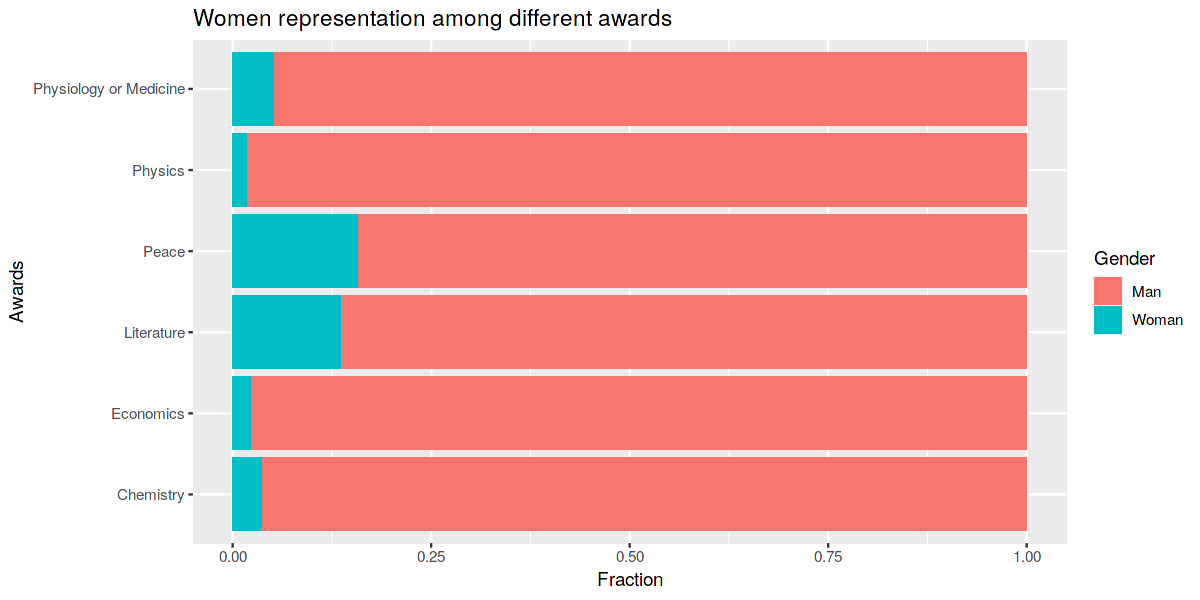

In [8]:
gender_category_data <- aggregate(Name ~ Category + Gender, data = data, FUN = length)
gender_category_data <- dcast(gender_category_data, Category ~ Gender)
gender_category_data$WomanPerc <- gender_category_data$Woman / (gender_category_data$Woman + gender_category_data$Man)
gender_category_data$ManPerc <- gender_category_data$Man / (gender_category_data$Woman + gender_category_data$Man)
gender_category_data$Organization <- NULL
gender_category_data$Man <- NULL
gender_category_data$Woman <- NULL
gender_category_data <- melt(gender_category_data, id.vars = 'Category')
gender_category_data$variable = as.factor(replace(as.character(gender_category_data$variable), gender_category_data$variable == 'ManPerc', 'Man'))
gender_category_data$variable = as.factor(replace(as.character(gender_category_data$variable), gender_category_data$variable == 'WomanPerc', 'Woman'))

options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(gender_category_data, aes(x = value, y = Category, fill = variable)) + geom_bar(stat = 'identity') + labs(title = 'Women representation among different awards', x = 'Fraction', y = 'Awards', fill = 'Gender')

It is evident from the graph that Nobel Prizes for Peace & Literature have much more women representation than others. This particular observation seemed similar to another of our previous insights - that Peace & Literature also have much more representation among countries.

This made me wonder whether there is some connection between how countries and women are represented since only Peace and Literature have higher country and women representations.

### Investigating why Nobel Prizes in Peace & Literature have better global distribution and also higher woman representation?

There could be two possibilities in my opinion - 
1. This is a coincidence. It is by chance that country representation is more in those Nobel Prize categories which have more women representation as well.
2. There exists some relationship that we have to analyze.

One possible relationship that I could think of was as follows -
We know that the global distribution of Nobel Laureates is dominated by a few 'dominant countries' like the USA, UK and Germany. Only for Peace and Literature do 'other countries' like Russia, China, India and South Africa also start having better representation. So could it be possible that the higher woman representation for Peace and Literature is because of these 'other countries'? Maybe these 'other countries' provide a higher women representation while the 'dominant countries' provide a very low women representation? Let us find out.

P-value for difference in women representation between 'dominant' and 'other' countries:
	Physics = 0.484
	Chemistry = 0.916
	Economics = 0.294
	Physiology or Medicine = 0.139
	Peace = 0.00356 *
	Literature = 0.834



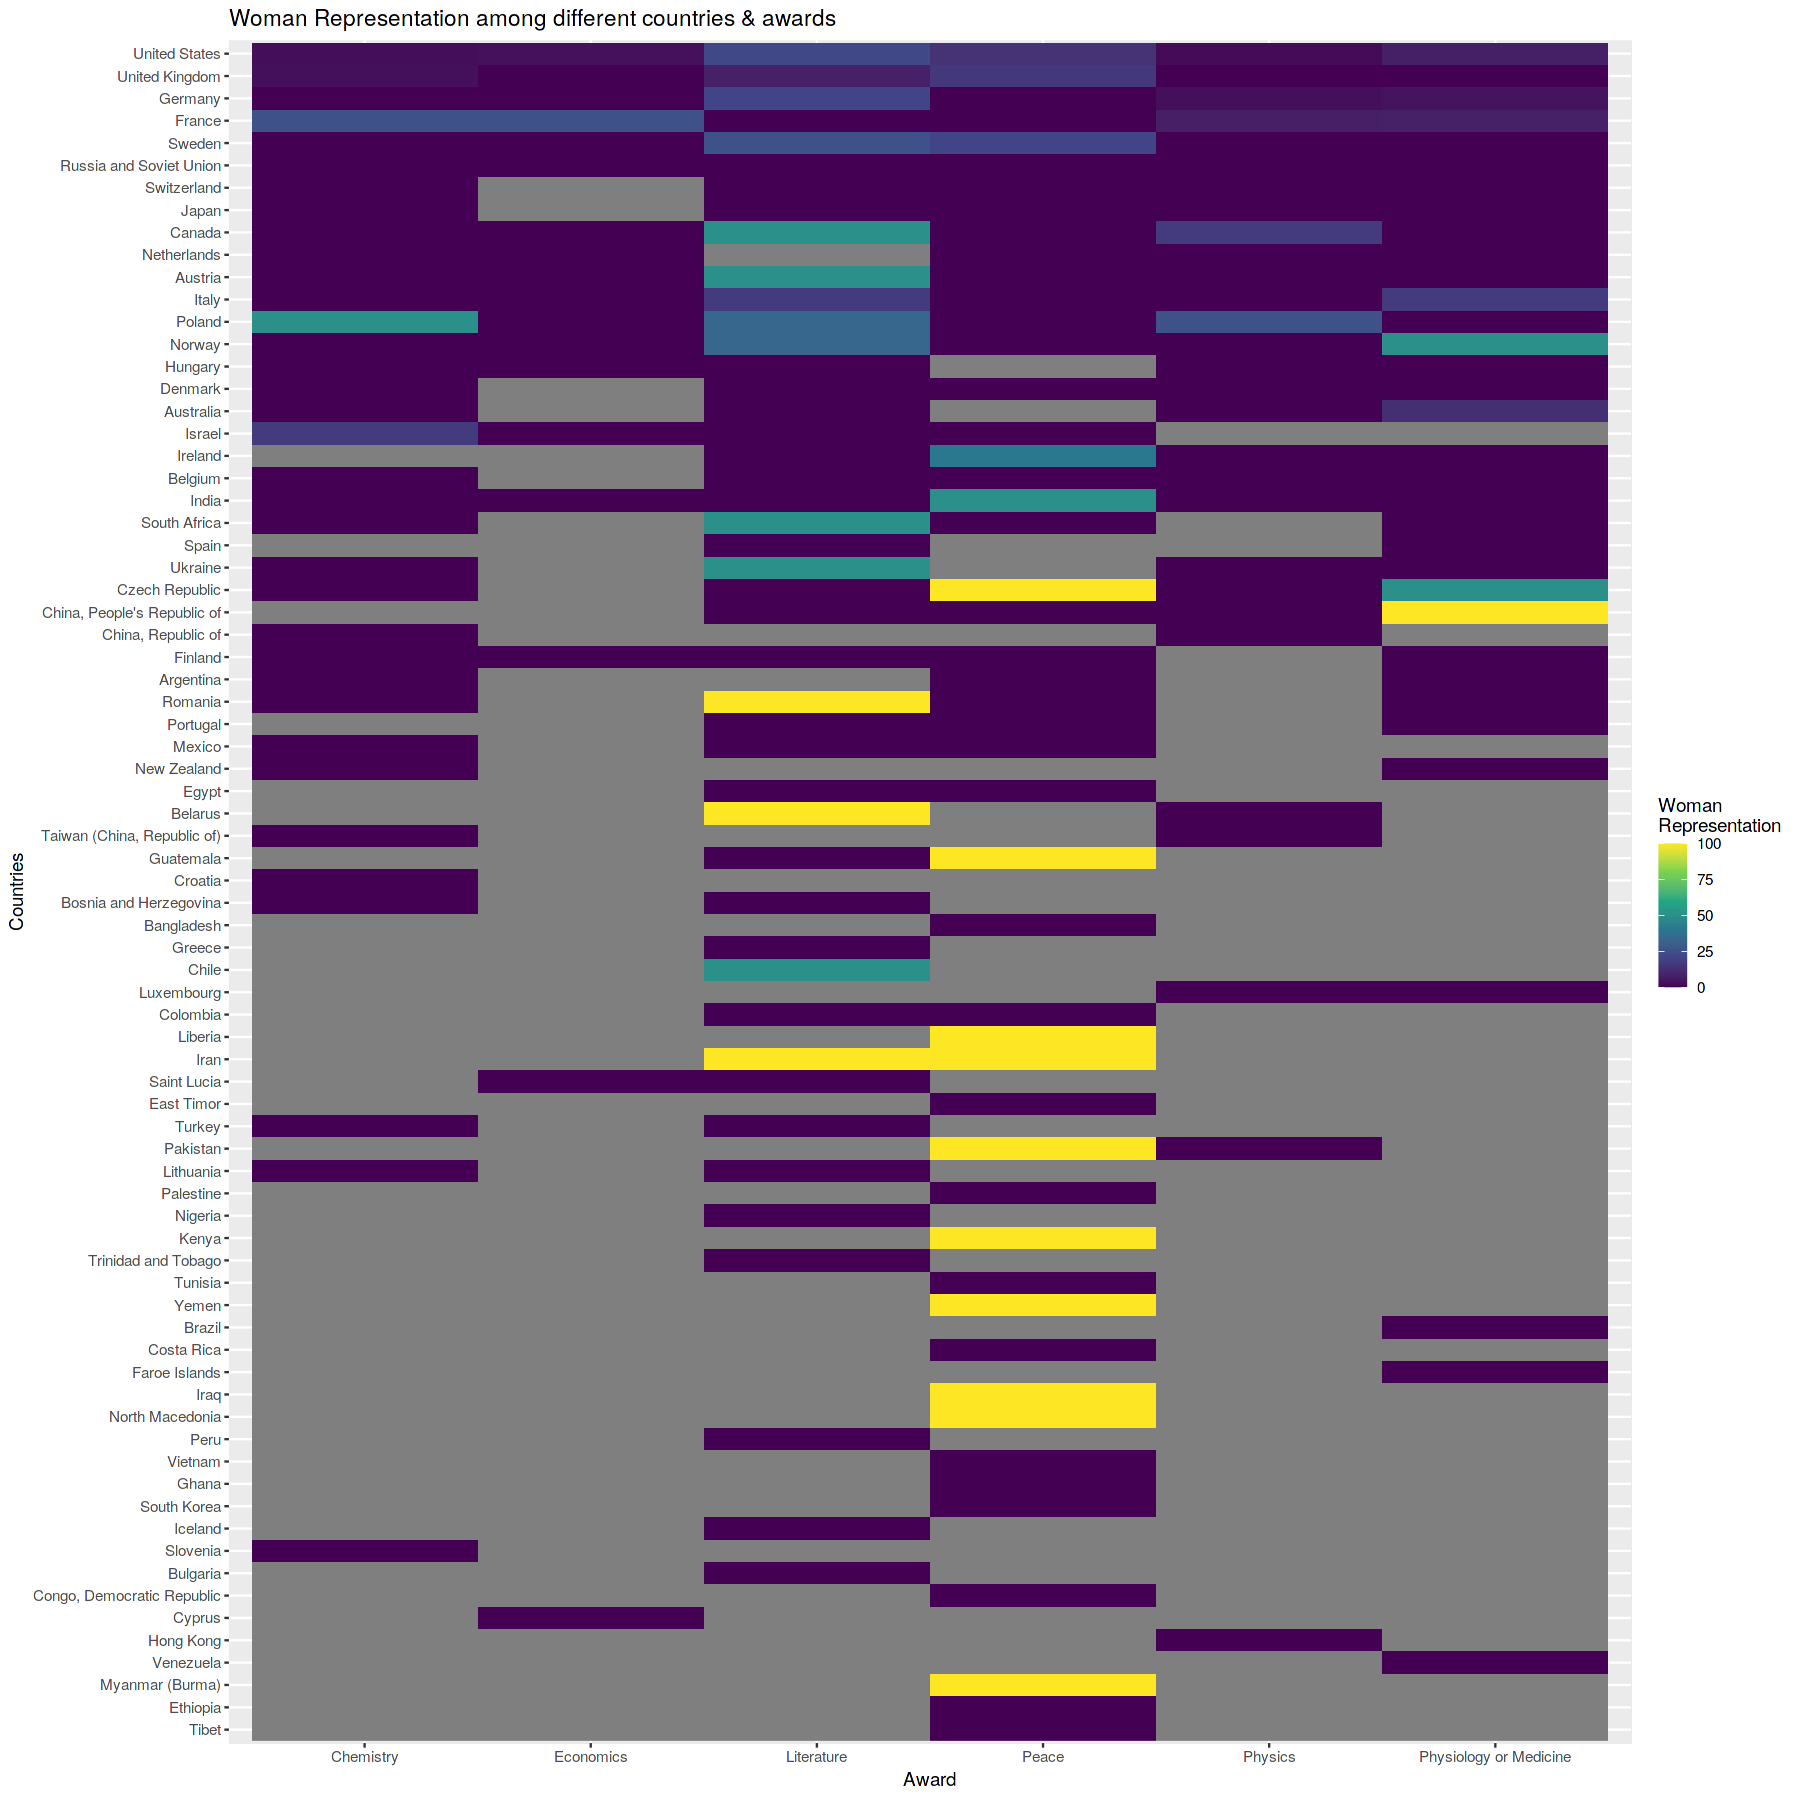

In [9]:
country_data <- raw_data[raw_data$Country != '-', ]
all_countries <- unique(country_data$Country)
all_award_categories <- unique(data$Category)
countries_all_repr <- as.data.frame(matrix(0, nrow = length(all_countries), ncol = length(all_award_categories)))
countries_woman_repr <- as.data.frame(matrix(0, nrow = length(all_countries), ncol = length(all_award_categories)))
rownames(countries_all_repr) <- all_countries
colnames(countries_all_repr) <- all_award_categories
rownames(countries_woman_repr) <- all_countries
colnames(countries_woman_repr) <- all_award_categories

for (idx1 in seq(length(all_countries)))
{
    for (idx2 in seq(dim(data)[1]))
    {
        if (grepl(all_countries[idx1], data[idx2, 'Countries'], fixed = TRUE))
        {
            countries_all_repr[all_countries[idx1], as.character(data[idx2, 'Category'])] <- countries_all_repr[all_countries[idx1], as.character(data[idx2, 'Category'])] + 1
            if(data[idx2, 'Gender'] == 'Woman')
                countries_woman_repr[all_countries[idx1], as.character(data[idx2, 'Category'])] <- countries_woman_repr[all_countries[idx1], as.character(data[idx2, 'Category'])] + 1
        }
    }
}
countries_woman_repr <- countries_woman_repr / (countries_all_repr) * 100

nobel_countries <- matrix(0, nrow = dim(data)[1], ncol = length(all_countries))
for (idx1 in seq(dim(data)[1]))
    for (idx2 in seq(length(all_countries)))
        if (grepl(all_countries[idx2], data[idx1, 'Countries'], fixed = TRUE))
            nobel_countries[idx1, idx2] <- 1
rowSum_nobel_countries <- colSums(nobel_countries)

countries_woman_repr <- rownames_to_column(countries_woman_repr, "countries")
countries_woman_repr$countries <- factor(countries_woman_repr$countries, levels = all_countries[order(rowSum_nobel_countries)])
countries_woman_repr <- pivot_longer(countries_woman_repr, -c(countries), names_to = "award", values_to = "woman_repr")
heat_plot <- ggplot(countries_woman_repr, aes(x = award, y = countries, fill = woman_repr)) + geom_raster() + scale_fill_viridis_c() + labs(title = 'Woman Representation among different countries & awards', x = 'Award', y = 'Countries', fill = 'Woman\nRepresentation')

cat("P-value for difference in women representation between 'dominant' and 'other' countries:\n")
for (award_category in unique(data$Category))
{
    category_woman_repr <- countries_woman_repr[countries_woman_repr$award == award_category, ]
    category_woman_repr <- category_woman_repr[!is.na(category_woman_repr$woman_repr), ]

    big_category_woman_repr <- category_woman_repr[category_woman_repr$countries %in% all_countries[order(rowSum_nobel_countries, decreasing = TRUE)][1:10], ]
    small_category_woman_repr <- category_woman_repr[!(category_woman_repr$countries %in% all_countries[order(rowSum_nobel_countries, decreasing = TRUE)][1:10]), ]

    big_category_woman_repr <- big_category_woman_repr$woman_repr
    small_category_woman_repr <- small_category_woman_repr$woman_repr
    var_test <- var.test(small_category_woman_repr, big_category_woman_repr)
    if(var_test$p.value >= 0.05) {
        t_test <- t.test(small_category_woman_repr, big_category_woman_repr, var.equal = TRUE)
    } else {
        t_test <- t.test(small_category_woman_repr, big_category_woman_repr, var.equal = FALSE)
    }
    cat(paste("\t", award_category, " = ", format(t_test$p.value, digits = 3), sep = ''))
    if(t_test$p.value < 0.05)
        cat(" *")
    cat('\n')
}

cat('\n')
options(repr.plot.width = 15, repr.plot.height = 15)
heat_plot

Plotted above are the women representation for different countries and categories. We are interested in the Peace & Literature categories and especially in comparing between the 'dominant countries' (the top 10 countries at the top of the plot) and the 'other countries' (the other countries at the bottom of the plot).

We can clearly see more yellow spots towards the bottom of the plot, indicating that the 'other countries' have higher women representation than the 'dominant countries'. This difference is much more evident for the Peace category. After calculating the p-values, we can confirm that the 'other countries' have statistically higher women representation than the 'dominant countries', but only for the Peace category.

This probably indicates that the dominant countries like USA, UK, Germany, etc. could be the reason why women representation is low. Another way of expressing this is that the dominant countries drive women representation down while the 'other countries' do their best to improve the women representation (atleast in the Peace category).

### Has the representation of women increased over time?

The biasness against women is a matter of the past. Have we done anything to ensure a better future? Let us look at the trend of women representation with time.

`geom_smooth()` using formula 'y ~ x'



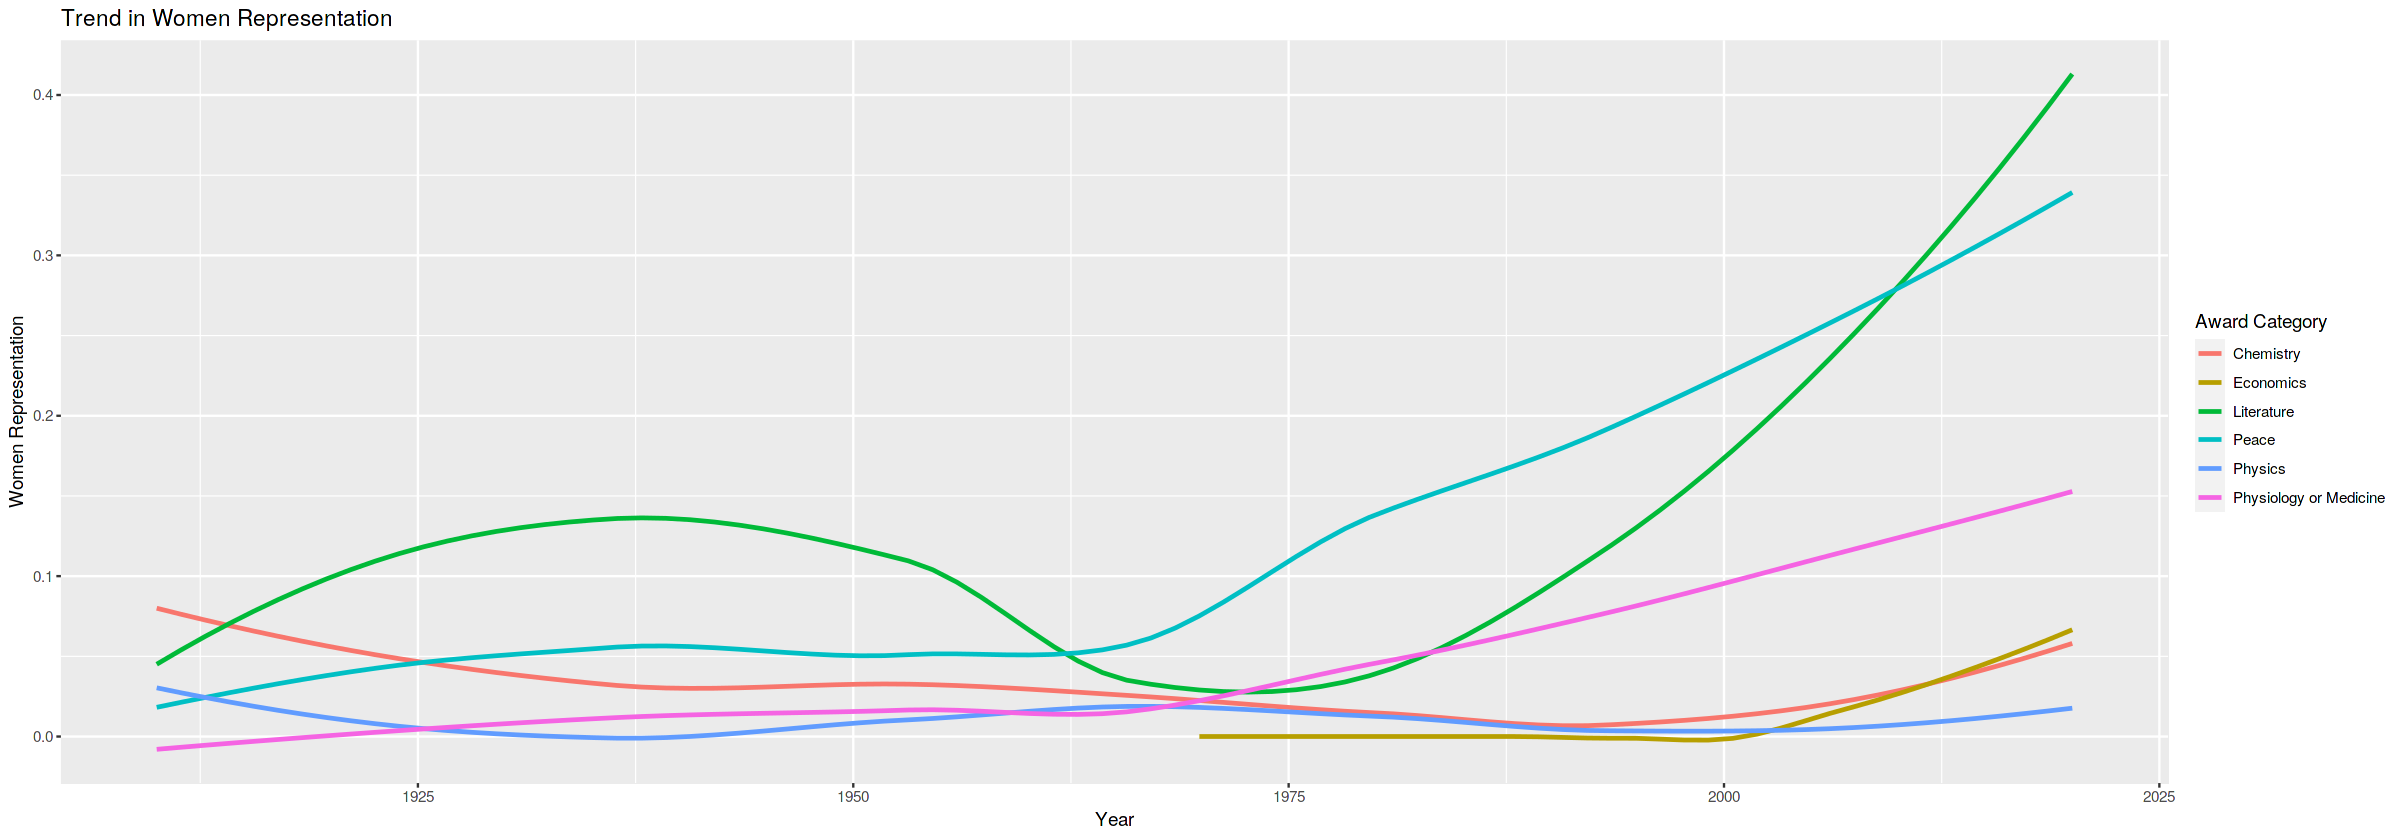

In [10]:
k <- 10

yearly_category_women_repr <- aggregate(Gender ~ Category + Year, data = data, FUN = function(x) sum(x == 'Woman'))
yearly_category_repr <- aggregate(Gender ~ Category + Year, data = data, FUN = length)
                                        
yearly_category_repr <- dcast(yearly_category_repr, Year ~ Category, value.var = 'Gender')
yearly_category_women_repr <- dcast(yearly_category_women_repr, Year ~ Category, value.var = 'Gender')
                                        
yearly_category_repr[is.na(yearly_category_repr)] <- 0
yearly_category_women_repr[is.na(yearly_category_women_repr)] <- 0
                                        
yearly_category_repr[, c('Economics', 'Peace', 'Literature', 'Chemistry', 'Physics', 'Physiology or Medicine')] <- apply(yearly_category_repr[, c('Economics', 'Peace', 'Literature', 'Chemistry', 'Physics', 'Physiology or Medicine')], MARGIN = 2, FUN = function(x) rollsumr(x, k = k, fill = NA))
yearly_category_women_repr[, c('Economics', 'Peace', 'Literature', 'Chemistry', 'Physics', 'Physiology or Medicine')] <- apply(yearly_category_women_repr[, c('Economics', 'Peace', 'Literature', 'Chemistry', 'Physics', 'Physiology or Medicine')], MARGIN = 2, FUN = function(x) rollsumr(x, k = k, fill = NA))
                                                                                                                               
yearly_category_repr <- yearly_category_repr[k:dim(yearly_category_repr)[1], ]
yearly_category_women_repr <- yearly_category_women_repr[k:dim(yearly_category_women_repr)[1], ]
                                                                                                                               
yearly_category_women_repr[, c('Economics', 'Peace', 'Literature', 'Chemistry', 'Physics', 'Physiology or Medicine')] <- yearly_category_women_repr[, c('Economics', 'Peace', 'Literature', 'Chemistry', 'Physics', 'Physiology or Medicine')] / yearly_category_repr[, c('Economics', 'Peace', 'Literature', 'Chemistry', 'Physics', 'Physiology or Medicine')]
                                                                                                                               
yearly_category_women_repr <- melt(yearly_category_women_repr, id.vars = 'Year')
                                                                                                                               
options(repr.plot.width = 20, repr.plot.height = 7)
ggplot(yearly_category_women_repr, aes(x = Year, y = value, colour = variable)) + geom_smooth(method = 'loess', na.rm = TRUE, se = FALSE, fullrange = TRUE) + labs(title = "Trend in Women Representation", x = "Year", y = "Women Representation", colour = "Award Category")

These are smoothed graphs of the trend. Again, peace and literature are the categories where women representation is showing a high upward slope while for other categories, it is indeed showing slight improvement. If this trend continues, then I hope it will lead to a point of acceptable women representation among Nobel Laureates in the near future.

## Age of Nobel Laureates <a id="3"></a>

### What is the average age of Nobel Laureates when they receive their Nobel Prize?

I always had this assumption that Nobel Prizes were only given to old people. This was to ensure that they made a sizeable contribution to the society. A person in his/her 30s is obviously less likely to make more contributions than when he/she would be 60, right?

Warning message:
“Removed 11 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 11 rows containing non-finite values (stat_boxplot).”


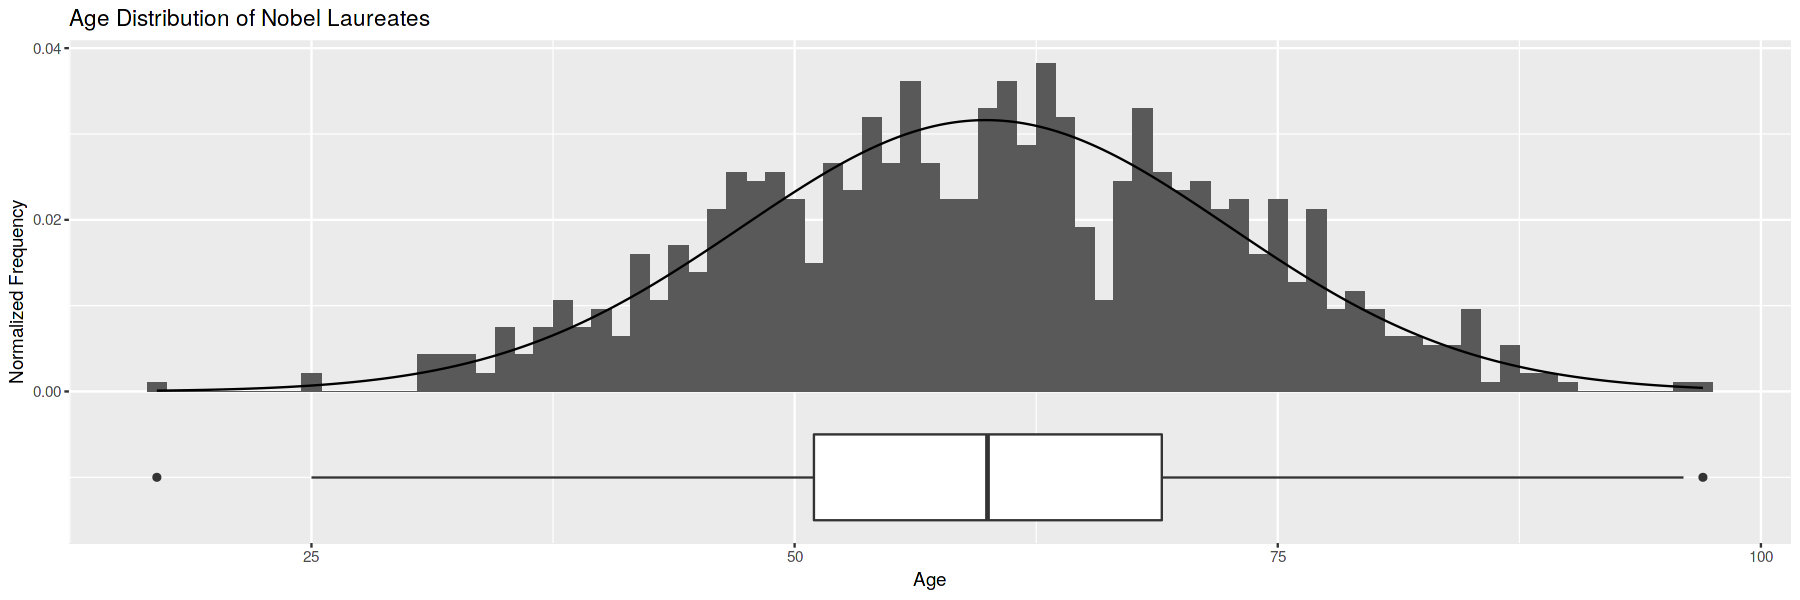

In [11]:
data$Age <- data$Year - data$BirthYr
num_ages <- length(data$Age[!is.na(data$Age)])
avg_ages <- mean(data$Age[!is.na(data$Age)])
std_ages <- sd(data$Age[!is.na(data$Age)])
options(repr.plot.width = 15, repr.plot.height = 5)
ggplot(data = data, aes(x = Age)) + geom_histogram(aes(y = stat(count / sum(count))), binwidth = 1) + geom_boxplot(aes(y = -0.01), width = 0.01) + stat_function(fun = dnorm, n = num_ages, args = list(mean = avg_ages, sd = std_ages)) + labs(title = "Age Distribution of Nobel Laureates", x = "Age", y = "Normalized Frequency")

Turns out that my hunch is pretty true. The average age of Nobel Laureates is between 55-65 while the IQR is from approximately 50-70. There are obviously a few exceptions here like Malala Yousafzai who was awarded the Nobel prize at the age of 17! Also a nice thing to notice here is that the age distribution fits incredibly well to a Gaussian curve as shown.

### What is the trend of age of Nobel Laureates with time?

Similar to previous analysis, let us identify the trend of Nobel Laureate age vs. time.

[1] "Avg. age is increasing by 0.124 every year!"


`geom_smooth()` using formula 'y ~ x'



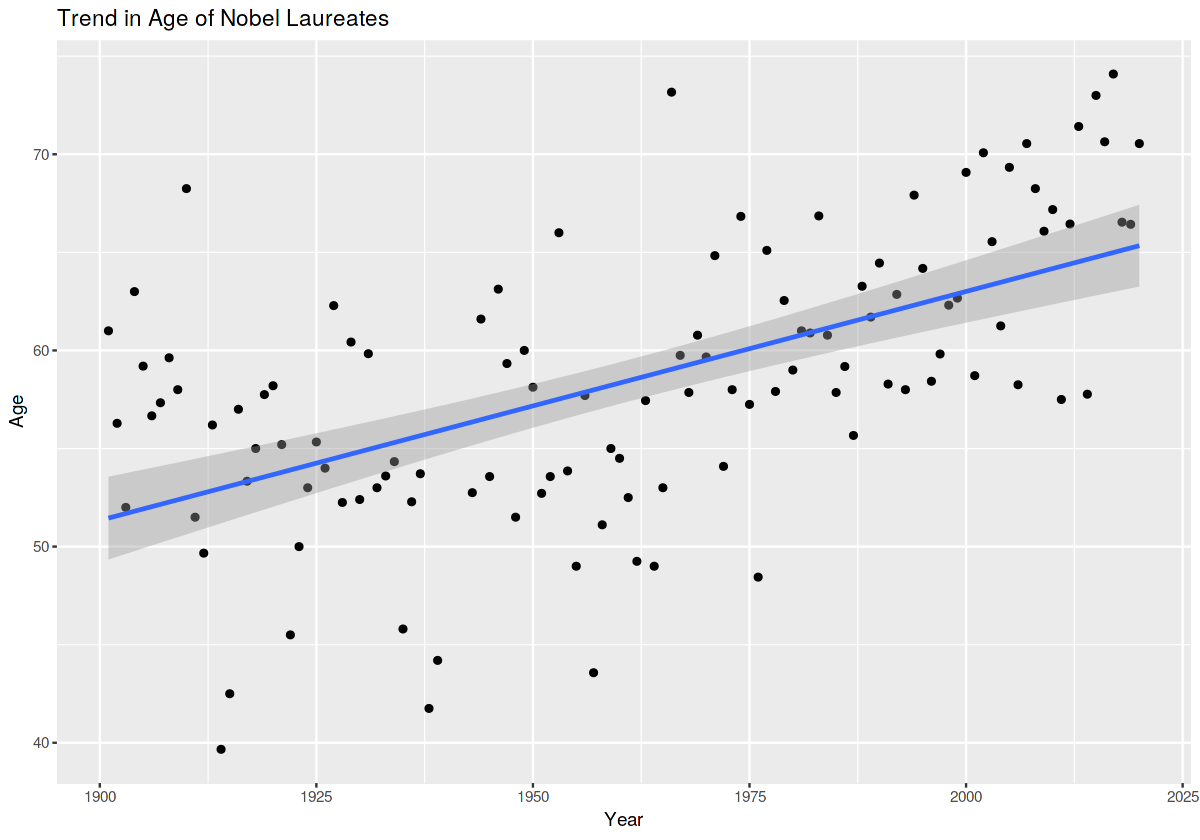

In [12]:
year_age_data <- aggregate(Age ~ Year, data = data, FUN = mean)
print(paste("Avg. age is increasing by ", format(as.numeric(lm(Age ~ Year, data = data)$coefficients['Year']), digits = 3), ' every year!', sep = ''))
options(repr.plot.width = 10, repr.plot.height = 7)
ggplot(year_age_data, aes(x = Year, y = Age)) + geom_point(stat = 'identity') + geom_smooth(method = "lm", se = TRUE) + labs(title = "Trend in Age of Nobel Laureates", x = "Year", y = 'Age')

As can be seen, the Nobel Laureate age seems to be slightly increase with time. In fact, it increases at an average rate of 0.124 per year. This means that since the start of the Nobel Prize in the 1900s, the average age has increased by almost 15 years!

### Are there awards/genders which boast significantly younger Nobel Laureates than others?

Again, let us compare the age distribution with different award categories and genders.

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Age ~ Category + Gender, data = data)

$Category
                                         diff        lwr        upr     p adj
Economics-Chemistry                 8.1969282   3.674826 12.7190300 0.0000041
Literature-Chemistry                6.0119750   1.920762 10.1031880 0.0004255
Peace-Chemistry                     2.1337898  -2.073380  6.3409593 0.6972698
Physics-Chemistry                  -2.5403023  -5.996107  0.9155024 0.2885373
Physiology or Medicine-Chemistry   -0.2136661  -3.648182  3.2208502 0.9999756
Literature-Economics               -2.1849533  -7.114817  2.7449103 0.8036943
Peace-Economics                    -6.0631384 -11.089649 -1.0366282 0.0078460
Physics-Economics                 -10.7372305 -15.154030 -6.3204312 0.0000000
Physiology or Medicine-Economics   -8.4105943 -12.810757 -4.0104315 0.0000009
Peace-Literature                   -3.8781852  -8.520860  0.7644892 0.162346

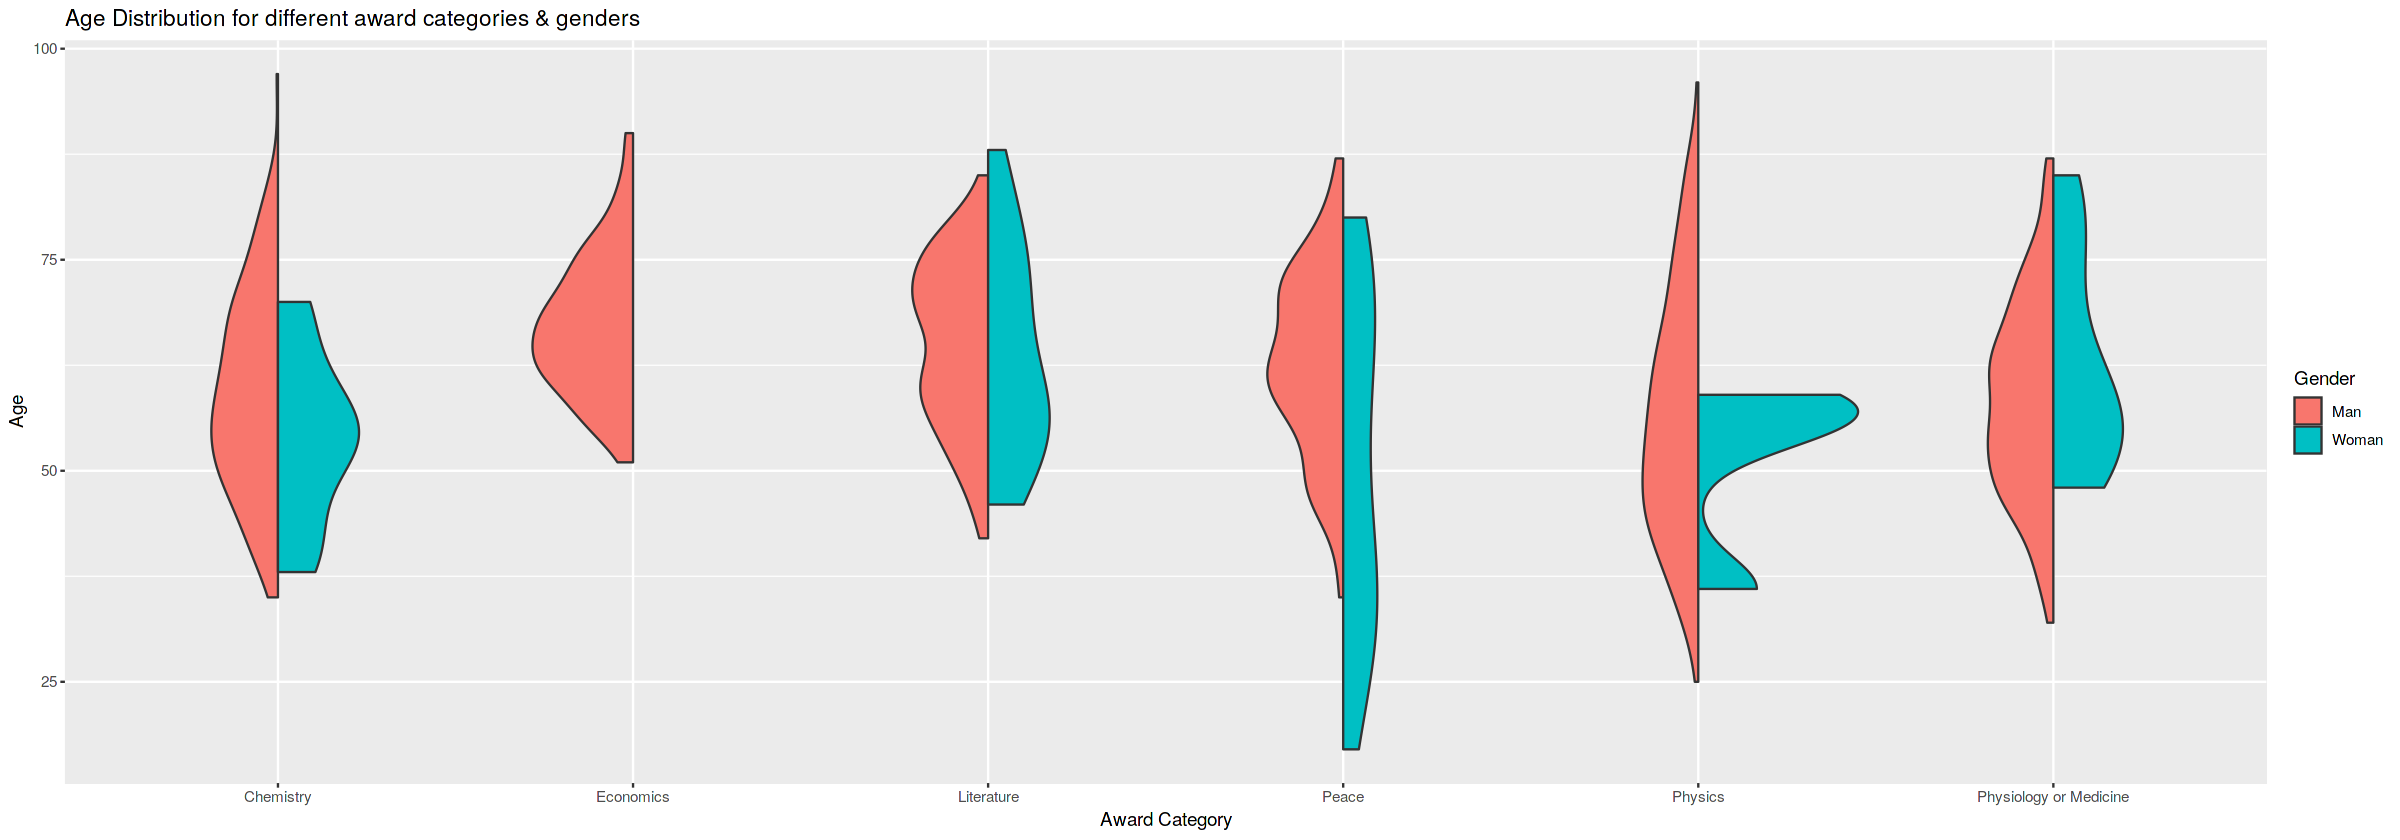

In [13]:
two_way_anova_model <- aov(Age ~ Category + Gender, data = data)
tukey_two_way <- TukeyHSD(two_way_anova_model)
print(tukey_two_way)

GeomSplitViolin <- ggproto("GeomSplitViolin", GeomViolin, 
                           draw_group = function(self, data, ..., draw_quantiles = NULL) {
  data <- transform(data, xminv = x - violinwidth * (x - xmin), xmaxv = x + violinwidth * (xmax - x))
  grp <- data[1, "group"]
  newdata <- plyr::arrange(transform(data, x = if (grp %% 2 == 1) xminv else xmaxv), if (grp %% 2 == 1) y else -y)
  newdata <- rbind(newdata[1, ], newdata, newdata[nrow(newdata), ], newdata[1, ])
  newdata[c(1, nrow(newdata) - 1, nrow(newdata)), "x"] <- round(newdata[1, "x"])

  if (length(draw_quantiles) > 0 & !scales::zero_range(range(data$y))) {
    stopifnot(all(draw_quantiles >= 0), all(draw_quantiles <=
      1))
    quantiles <- ggplot2:::create_quantile_segment_frame(data, draw_quantiles)
    aesthetics <- data[rep(1, nrow(quantiles)), setdiff(names(data), c("x", "y")), drop = FALSE]
    aesthetics$alpha <- rep(1, nrow(quantiles))
    both <- cbind(quantiles, aesthetics)
    quantile_grob <- GeomPath$draw_panel(both, ...)
    ggplot2:::ggname("geom_split_violin", grid::grobTree(GeomPolygon$draw_panel(newdata, ...), quantile_grob))
  }
  else {
    ggplot2:::ggname("geom_split_violin", GeomPolygon$draw_panel(newdata, ...))
  }
})

geom_split_violin <- function(mapping = NULL, data = NULL, stat = "ydensity", position = "identity", ..., 
                              draw_quantiles = NULL, trim = TRUE, scale = "area", na.rm = FALSE, 
                              show.legend = NA, inherit.aes = TRUE) {
  layer(data = data, mapping = mapping, stat = stat, geom = GeomSplitViolin, 
        position = position, show.legend = show.legend, inherit.aes = inherit.aes, 
        params = list(trim = trim, scale = scale, draw_quantiles = draw_quantiles, na.rm = na.rm, ...))
}
                           
options(repr.plot.width = 20, repr.plot.height = 7)
ggplot(data[data$Gender != 'Organization', ], aes(x = Category, y = Age, fill = Gender)) + geom_split_violin() + labs(title = "Age Distribution for different award categories & genders", x = "Award Category", y = "Age", fill = "Gender")

This fun-looking violin plot shows how age varies with category and gender. Do note that there have been only two female Nobel Laureates in Economics, because of which I wasn't able to show the corresponding violin plot due to insufficient data.

There wasn't any obvious trend that I was able to find in the violin plots. However, upon performing ANOVA analysis and Tukey tests, I was able to identify certain pairs of categories which have a significant difference in average age (the 'p adj' value should be <0.05). Further, the age difference between male and female Nobel Laureates was also found to be statistically significant.

## Popularity of Nobel Laureates <a id="4"></a>

### Who are the most popular/celebrated/searched-for Nobel Laureates?

This is something that excited and fascinated me. I wanted to find interesting facts about how popular Nobel Laureates really are and how the Nobel prize affected their popularity.

To quantify popularity, I'm using the metric of Wikipedia Page views. The more views a person's wikipedia page gets, the more popular I assume that person is. Fair enough?

**NOTE:** The Wikipedia Page View metrics only go as far as July 2015. So we are essentially looking at how popular a person has been for the last five years or so.

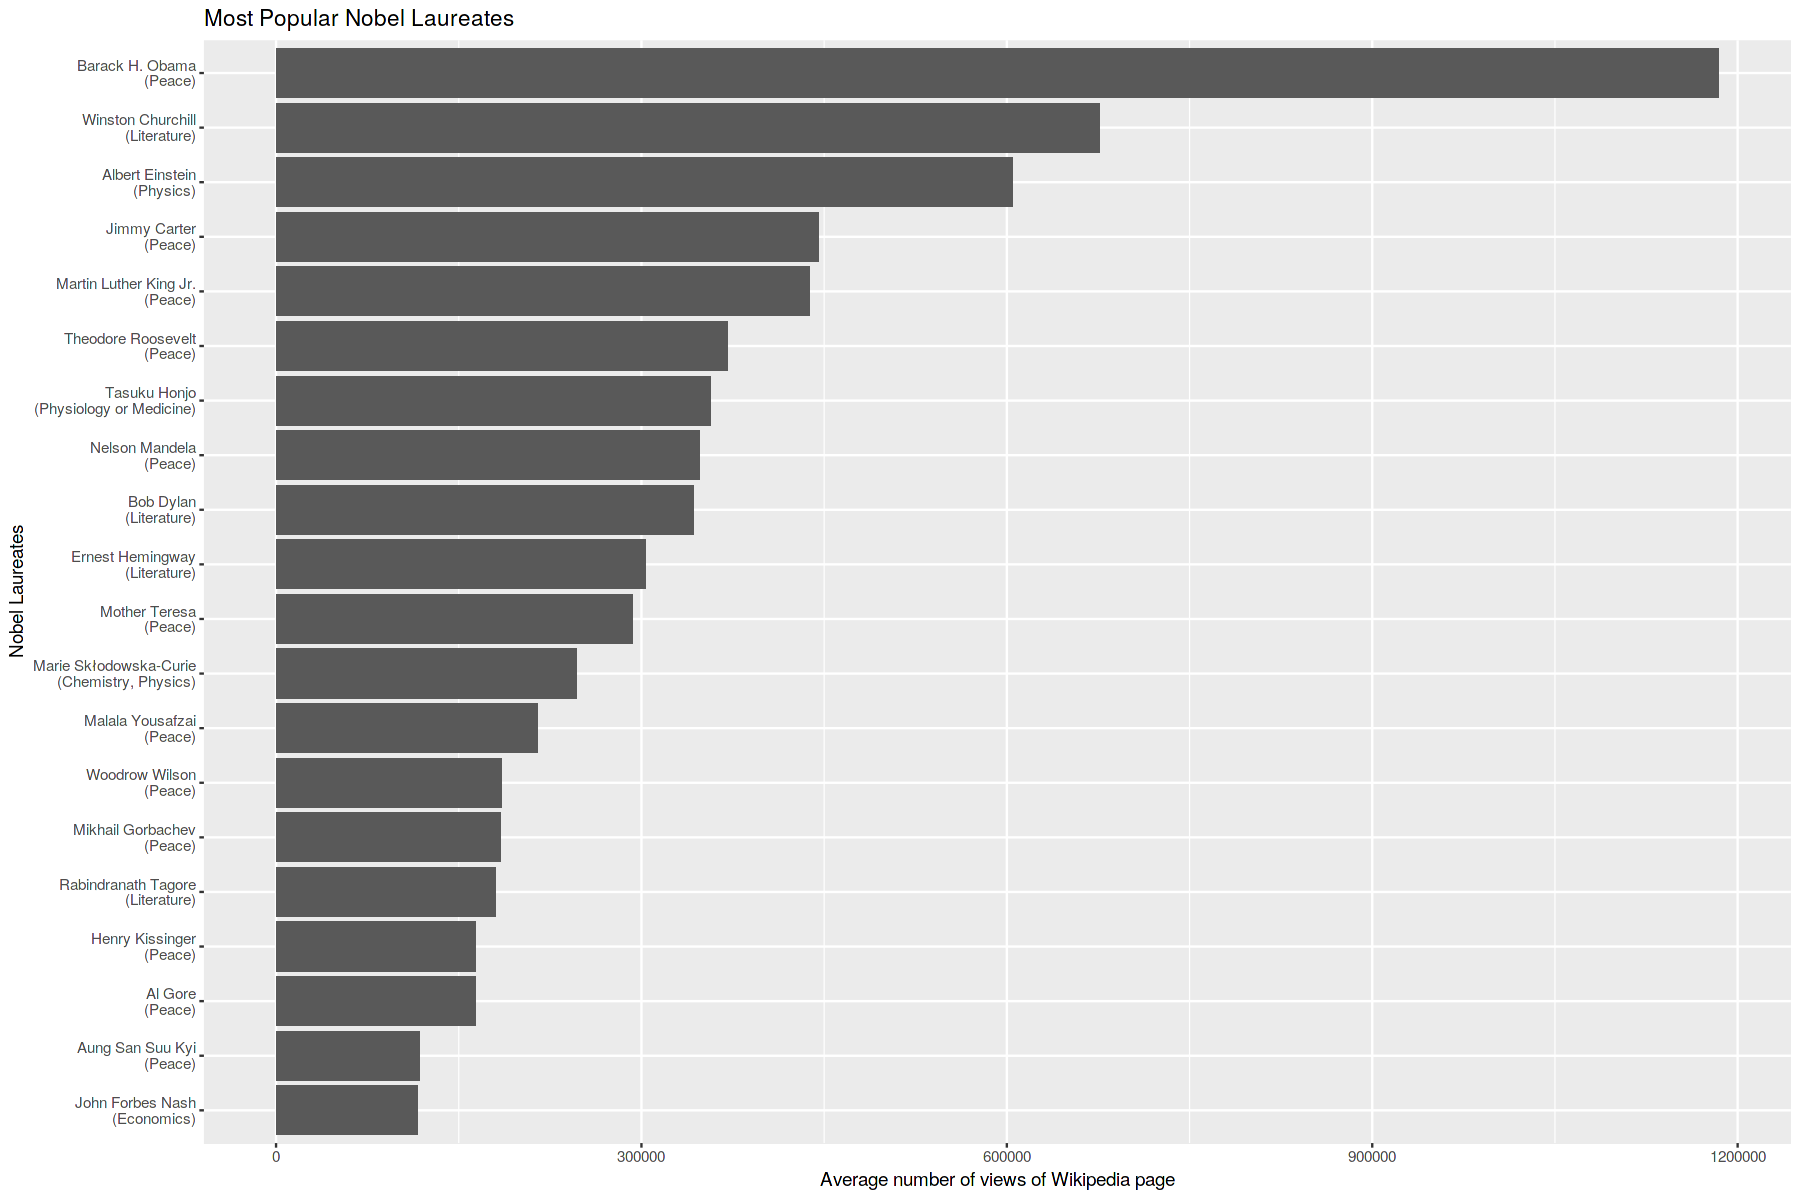

In [14]:
views_df <- read.csv('../input/nobel-laureates-wikipedia-views/view_data.csv', row.names = 1)
colnames(views_df) <- sapply(colnames(views_df), function(x) substring(x, 2))

views_df$Avg_Pop <- rowMeans(views_df, na.rm = TRUE)
views_df <- merge(data, views_df, by.x = 'Name', by.y = 0, all = TRUE)

avg_pop_df <- aggregate(Avg_Pop ~ Name, data = views_df, FUN = mean)
name_category_mapping <- aggregate(Category ~ Name, data = views_df, FUN = toString)
avg_pop_df <- merge(avg_pop_df, name_category_mapping, by = 'Name')
avg_pop_df <- avg_pop_df[order(avg_pop_df$Avg_Pop, decreasing = TRUE), ]

concat_name_category <- function(name, category) {
    paste(name, '\n(', category, ')', sep = '')
}
concat_name_category <- Vectorize(concat_name_category)
avg_pop_df$Name <- concat_name_category(avg_pop_df$Name, avg_pop_df$Category)
rownames(avg_pop_df) <- NULL
                             
options(repr.plot.width = 15, repr.plot.height = 10)
ggplot(avg_pop_df[1:20, ], aes(y = reorder(Name, Avg_Pop), x = Avg_Pop)) + geom_bar(stat = 'identity') + labs(title = "Most Popular Nobel Laureates", x = "Average number of views of Wikipedia page", y = "Nobel Laureates")

So let's see who's the most famous Nobel Laureate - it's President Obama. He was awarded the Nobel Peace Prize in 2009 and did continue to be the president of the USA till 2017 by which time his popularity must have reached very high.

It is also worth noting that one might assume living celebrities like Obama to be more popular and relevant today than deceased celebrities. But that is not the case - Sir Winston Churchill, Albert Einstein, Martin Luther King Jr. and Theodore Roosevelt, though deceased, are still popular today.

Another really interesting aspect to observe in the plot is the category of Nobel Prize that the individuals won - most of them are Peace. This is probably because few Nobel Peace Prizes have been awarded to presidents, ministers, politicians and activists - people who need to be popular and relevant among the masses in order to do their job or spread awareness. On the other hand, fame/popularity is usually not of concern to scientists who can still do their job without being seen.

### Do the Nobel Laureates experience a significant boost in popularity when they are awarded the Nobel prize?

This is also something that I do think about. Let's say tomorrow it is announced that I will win the Nobel Prize in Physiology or Medicine. Obviously, not a lot of people know about me (sob...), so they'll start searching me up on Google & Wikipedia, boosting my popularity. However, after the Award Ceremony, people will go back to not caring who I am (sob...).

This made me wonder whether Nobel Laureates experience a boost in popularity during the time period when they receive their Nobel Prize and does that boost in popularity eventually die off?

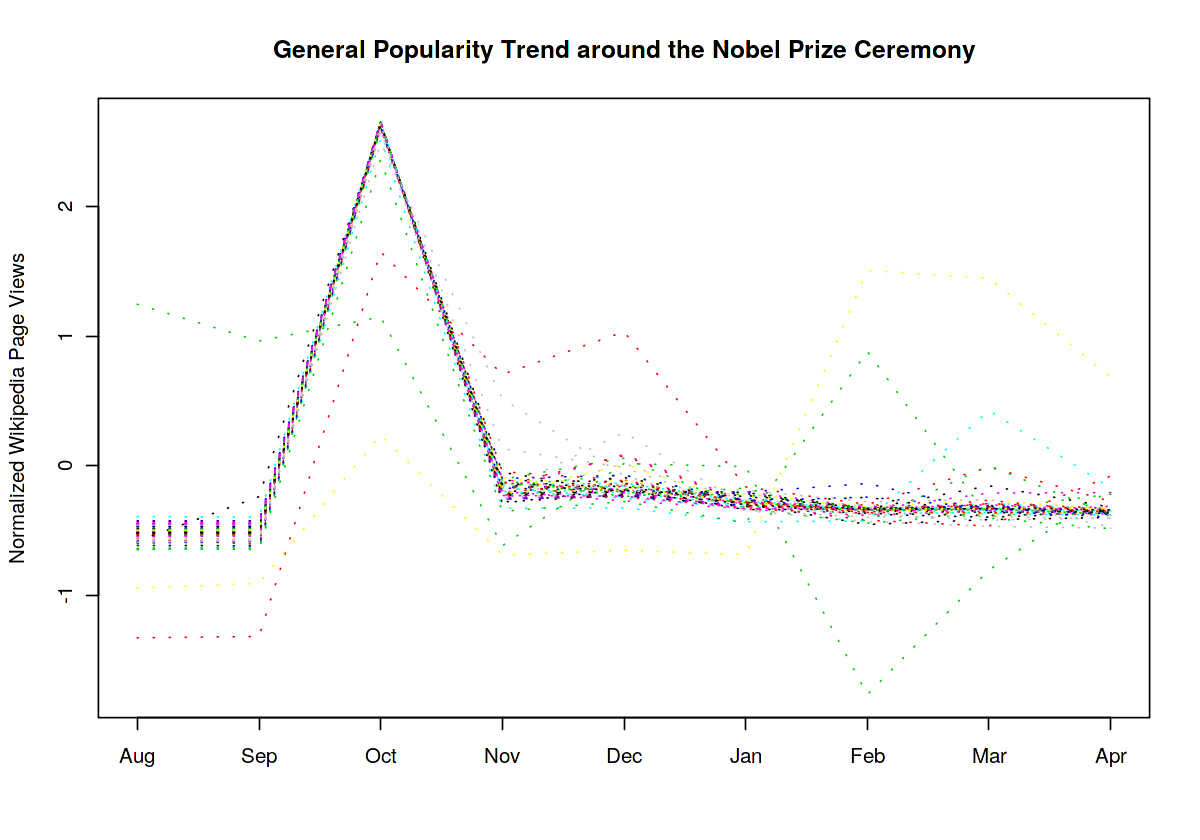

In [15]:
latest_views_df <- views_df[views_df$Year >= 2015, ]
rownames(latest_views_df) <- NULL

popularity_window <- list(
    '2015' = c('2015.08.01', '2015.09.01', '2015.10.01', '2015.11.01', '2015.12.01', '2016.01.01', '2016.02.01', '2016.03.01', '2016.04.01'),
    '2016' = c('2016.08.01', '2016.09.01', '2016.10.01', '2016.11.01', '2016.12.01', '2017.01.01', '2017.02.01', '2017.03.01', '2017.04.01'),
    '2017' = c('2017.08.01', '2017.09.01', '2017.10.01', '2017.11.01', '2017.12.01', '2018.01.01', '2018.02.01', '2018.03.01', '2018.04.01'),
    '2018' = c('2018.08.01', '2018.09.01', '2018.10.01', '2018.11.01', '2018.12.01', '2019.01.01', '2019.02.01', '2019.03.01', '2019.04.01'),
    '2019' = c('2019.08.01', '2019.09.01', '2019.10.01', '2019.11.01', '2019.12.01', '2020.01.01', '2020.02.01', '2020.03.01', '2020.04.01'),
    '2020' = c('2020.08.01', '2020.09.01', '2020.10.01', '2020.11.01', '2020.12.01', '2021.01.01', '2021.02.01', '2021.03.01', '2021.04.01')
)

latest_views <- matrix(0, nrow = dim(latest_views_df)[1], ncol = 9)
for(idx in seq(dim(latest_views_df)[1]))
{
    year <- latest_views_df[idx, 'Year']
    latest_vals <- latest_views_df[idx, unlist(popularity_window[as.character(year)])]
    latest_views[idx, ] <- unlist(latest_vals)
}
latest_views <- apply(latest_views, 1, function(x) (x - mean(x)) / (sd(x) + 0.000000000000001))
                      
options(repr.plot.width = 10, repr.plot.height = 7)
matplot(latest_views, type = 'l', pch = 1, col = 1:dim(latest_views)[1], lty = '1F', ann = FALSE, xaxt = 'n')
title(main = "General Popularity Trend around the Nobel Prize Ceremony", ylab = "Normalized Wikipedia Page Views")
axis(1, seq(9), c('Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'))

The plot above shows the trend of popularity of all Nobel Prize winners (after 2015) during their respective Nobel Prize ceremony. For example, in the case of a 2017 Nobel Laureate, we start tracking his/her popularity from August 2017 to April 2018. This time period is centered around December 2017, which is when the Nobel Prize would have been awarded to our Nobel Laureate.

To my delight, the general trend was exactly how I expected - a sudden spike in popularity followed by a return to normalcy. However, the spike was observed not in December (when the Nobel Prizes are actually awarded) but in October. Upon some research, I found out that although Nobel Prizes are awarded in December, the winners of the imminent Nobel Prizes are actually announced in October. This made sense, since immediately after the announcement in October, people will be curious to know who the soon-to-be Nobel Laureates are. And this curiousness will quickly fade away some time after the announcements.

What surprised me was how consistent this pattern was. As shown, barring a few exceptions, this pattern is exactly the same for almost all the Nobel Laureates after 2015!

# Thank You!

### Hope you enjoyed this analysis as much as I did. Feel free to go through my R codes if you wish. If you find any error in my approach or have any suggestion, do let me know. I hope this notebook atleast taught you something interesting/unique today!